# Bitcoin's Realized Volatility Forecasting with GARCH and Multivariate LSTM

### Installing & Importing Libraries 

In [1]:
# !pip install arch

In [13]:
# !pip3 install yfinance

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
pd.set_option('display.max_colwidth', None)
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('images')

### Load Data from `yfinance`

In [10]:
seed = 2023
start = datetime(2015, 1, 1)
end = datetime(2023, 11, 30)

tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

In [11]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2015-01-01 00:00:00+00:00  320.434998  320.434998  314.002991  314.248993   
2015-01-02 00:00:00+00:00  314.079010  315.838989  313.565002  315.032013   
2015-01-03 00:00:00+00:00  314.846008  315.149994  281.082001  281.082001   
2015-01-04 00:00:00+00:00  281.145996  287.230011  257.612000  264.195007   
2015-01-05 00:00:00+00:00  265.084015  278.341003  265.084015  274.473999   

                             Volume  Dividends  Stock Splits  
Date                                                          
2015-01-01 00:00:00+00:00   8036550        0.0           0.0  
2015-01-02 00:00:00+00:00   7860650        0.0           0.0  
2015-01-03 00:00:00+00:00  33054400        0.0           0.0  
2015-01-04 00:00:00+00:00  55629100        0.0           0.0  
2015-01-05 00:00:00+00:00  43962800        0.0           0.0

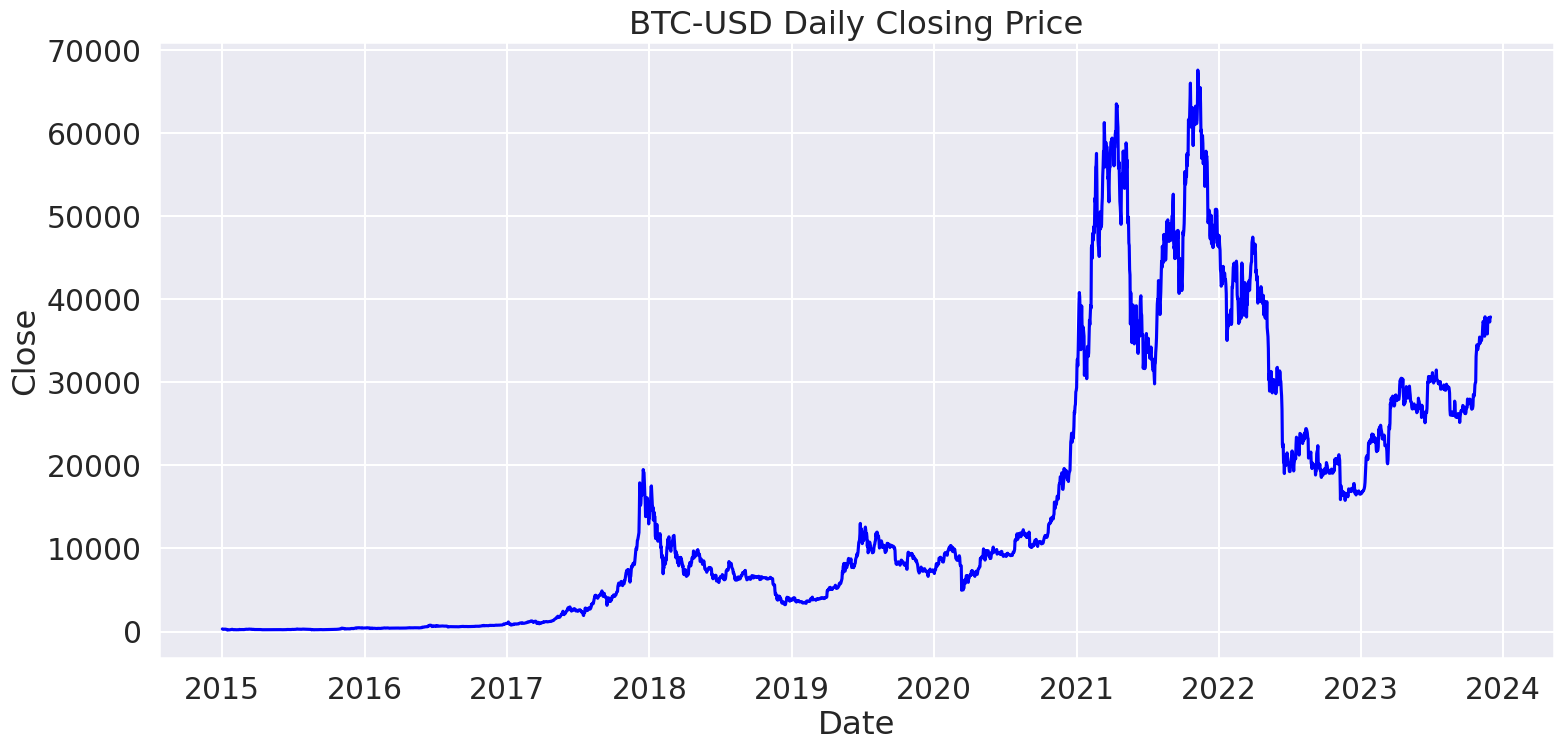

In [12]:
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2015
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    

# plt.tight_layout()
plt.savefig(os.path.join(directory_to_img, 'close.png'), 
            dpi=300, bbox_inches='tight');

In [15]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()
# CALCULATE LOG RETURNS
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [16]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2015-01-01 00:00:00+00:00  320.434998  320.434998  314.002991  314.248993   
2015-01-02 00:00:00+00:00  314.079010  315.838989  313.565002  315.032013   
2015-01-03 00:00:00+00:00  314.846008  315.149994  281.082001  281.082001   
2015-01-04 00:00:00+00:00  281.145996  287.230011  257.612000  264.195007   
2015-01-05 00:00:00+00:00  265.084015  278.341003  265.084015  274.473999   

                             Volume  Dividends  Stock Splits    returns  \
Date                                                                      
2015-01-01 00:00:00+00:00   8036550        0.0           0.0        NaN   
2015-01-02 00:00:00+00:00   7860650        0.0           0.0   0.249172   
2015-01-03 00:00:00+00:00  33054400        0.0           0.0 -10.776686   
2015-01-04 00:00:00+00:00  55629100        0.0           0.0  -6.007853   
2015-01-05 00:00:00+00:00  43962800        0.0           0.0   3.890684   

                           log_returns  
Date                                    
2015-01-01 00:00:00+00:00          NaN  
2015-01-02 00:00:00+00:00     0.002489  
2015-01-03 00:00:00+00:00    -0.114028  
2015-01-04 00:00:00+00:00    -0.061959  
2015-01-05 00:00:00+00:00     0.038169

In [17]:
df.dropna(inplace=True)

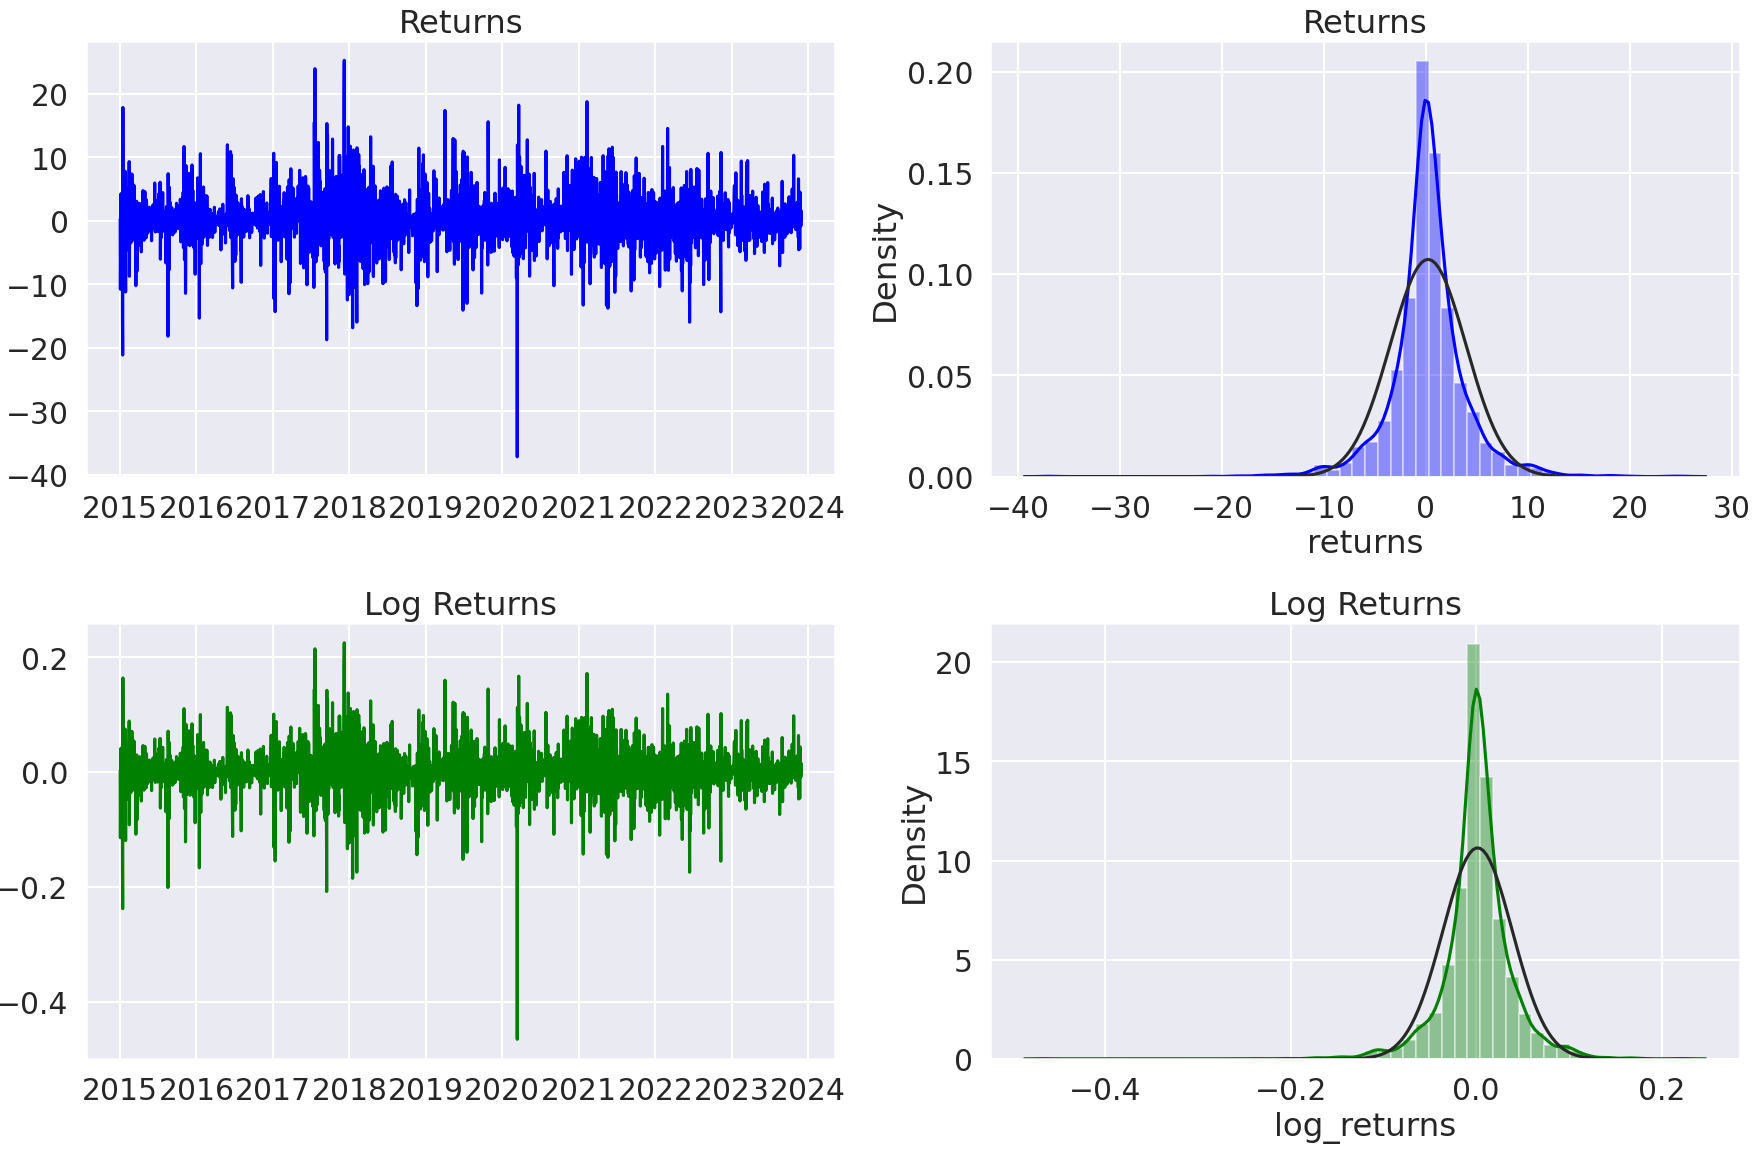

In [18]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'returns_logreturns.png'), 
                dpi=300, bbox_inches='tight')
    fig.show();

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


In [19]:
df.returns.describe()

count    3254.000000
mean        0.217184
std         3.719741
min       -37.169539
25%        -1.218169
50%         0.139420
75%         1.705273
max        25.247169
Name: returns, dtype: float64

In [20]:
df.log_returns.describe()

count    3254.000000
mean        0.001472
std         0.037505
min        -0.464730
25%        -0.012256
50%         0.001393
75%         0.016909
max         0.225119
Name: log_returns, dtype: float64

In [21]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [22]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values
    vols_df[i] = vols

vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

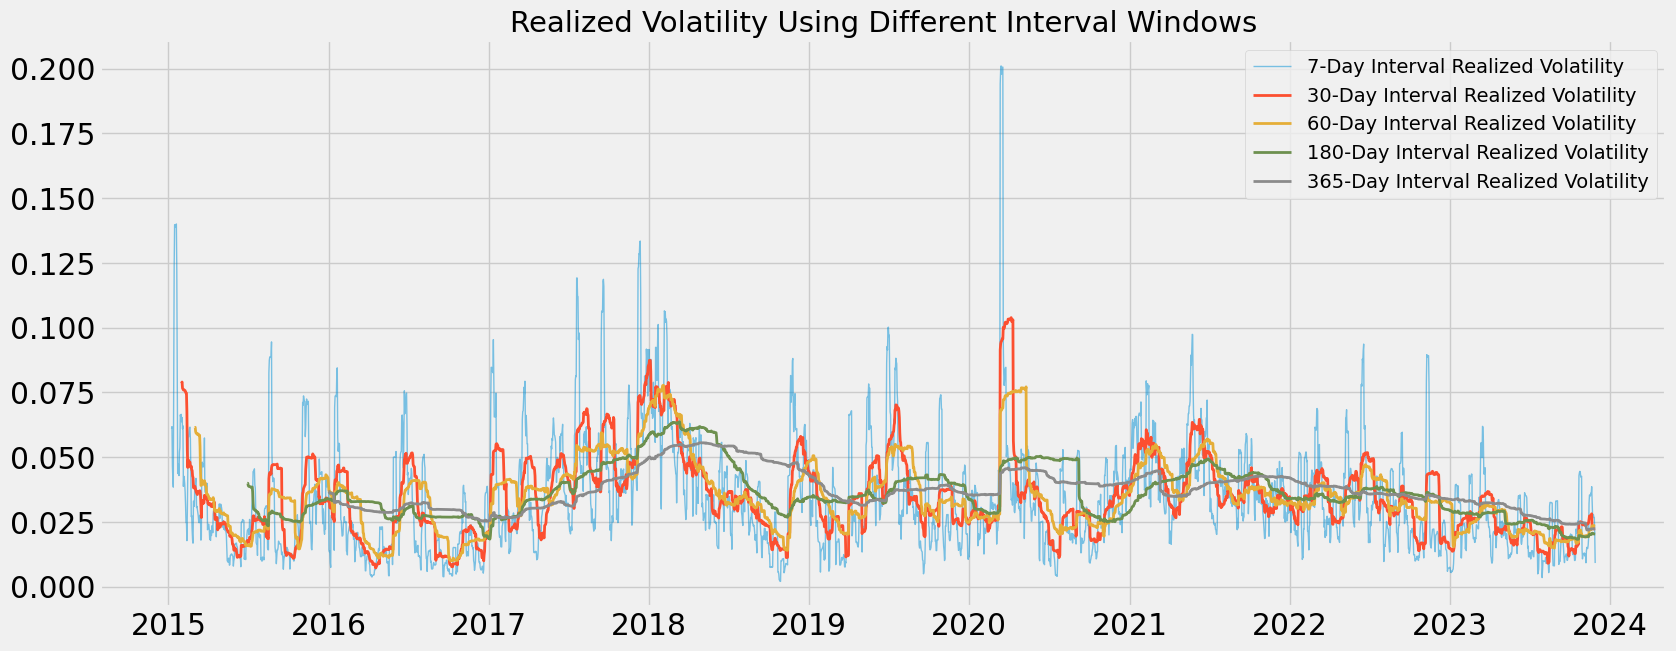

In [23]:
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.savefig(os.path.join(directory_to_img, 'diff_intervals.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [24]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [25]:
df.describe()

Open          High           Low         Close        Volume  \
count   3254.000000   3254.000000   3254.000000   3254.000000  3.254000e+03   
mean   14766.973679  15114.587376  14391.528999  14777.148961  1.702777e+10   
std    16092.333243  16483.162390  15651.785553  16092.362246  1.922683e+10   
min      176.897003    211.731003    171.509995    178.102997  7.860650e+06   
25%     1173.674957   1191.637482   1157.277466   1176.187469  3.152658e+08   
50%     8535.900391   8724.288574   8270.207031   8556.607422  1.246005e+10   
75%    23807.817871  24304.578125  23288.834961  23835.286621  2.742469e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     3254.0        3254.0  3254.000000  3254.000000  3225.000000   
mean         0.0           0.0     0.217184     0.001472     0.034377   
std          0.0           0.0     3.719741     0.037505     0.015977   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.218169    -0.012256     0.023506   
50%          0.0           0.0     0.139420     0.001393     0.032123   
75%          0.0           0.0     1.705273     0.016909     0.043333   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  3218.000000  
mean      0.034285  
std       0.015871  
min       0.007228  
25%       0.023464  
50%       0.032097  
75%       0.043311  
max       0.103878

In [26]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [27]:
df.describe()

Open          High           Low         Close        Volume  \
count   3254.000000   3254.000000   3254.000000   3254.000000  3.254000e+03   
mean   14766.973679  15114.587376  14391.528999  14777.148961  1.702777e+10   
std    16092.333243  16483.162390  15651.785553  16092.362246  1.922683e+10   
min      176.897003    211.731003    171.509995    178.102997  7.860650e+06   
25%     1173.674957   1191.637482   1157.277466   1176.187469  3.152658e+08   
50%     8535.900391   8724.288574   8270.207031   8556.607422  1.246005e+10   
75%    23807.817871  24304.578125  23288.834961  23835.286621  2.742469e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3254.000000  3254.000000  3225.000000  3218.000000  
mean      0.217184     0.001472     0.034377     0.034285  
std       3.719741     0.037505     0.015977     0.015871  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.218169    -0.012256     0.023506     0.023464  
50%       0.139420     0.001393     0.032123     0.032097  
75%       1.705273     0.016909     0.043333     0.043311  
max      25.247169     0.225119     0.103878     0.103878

In [28]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

## **Exploratory Data Analysis**

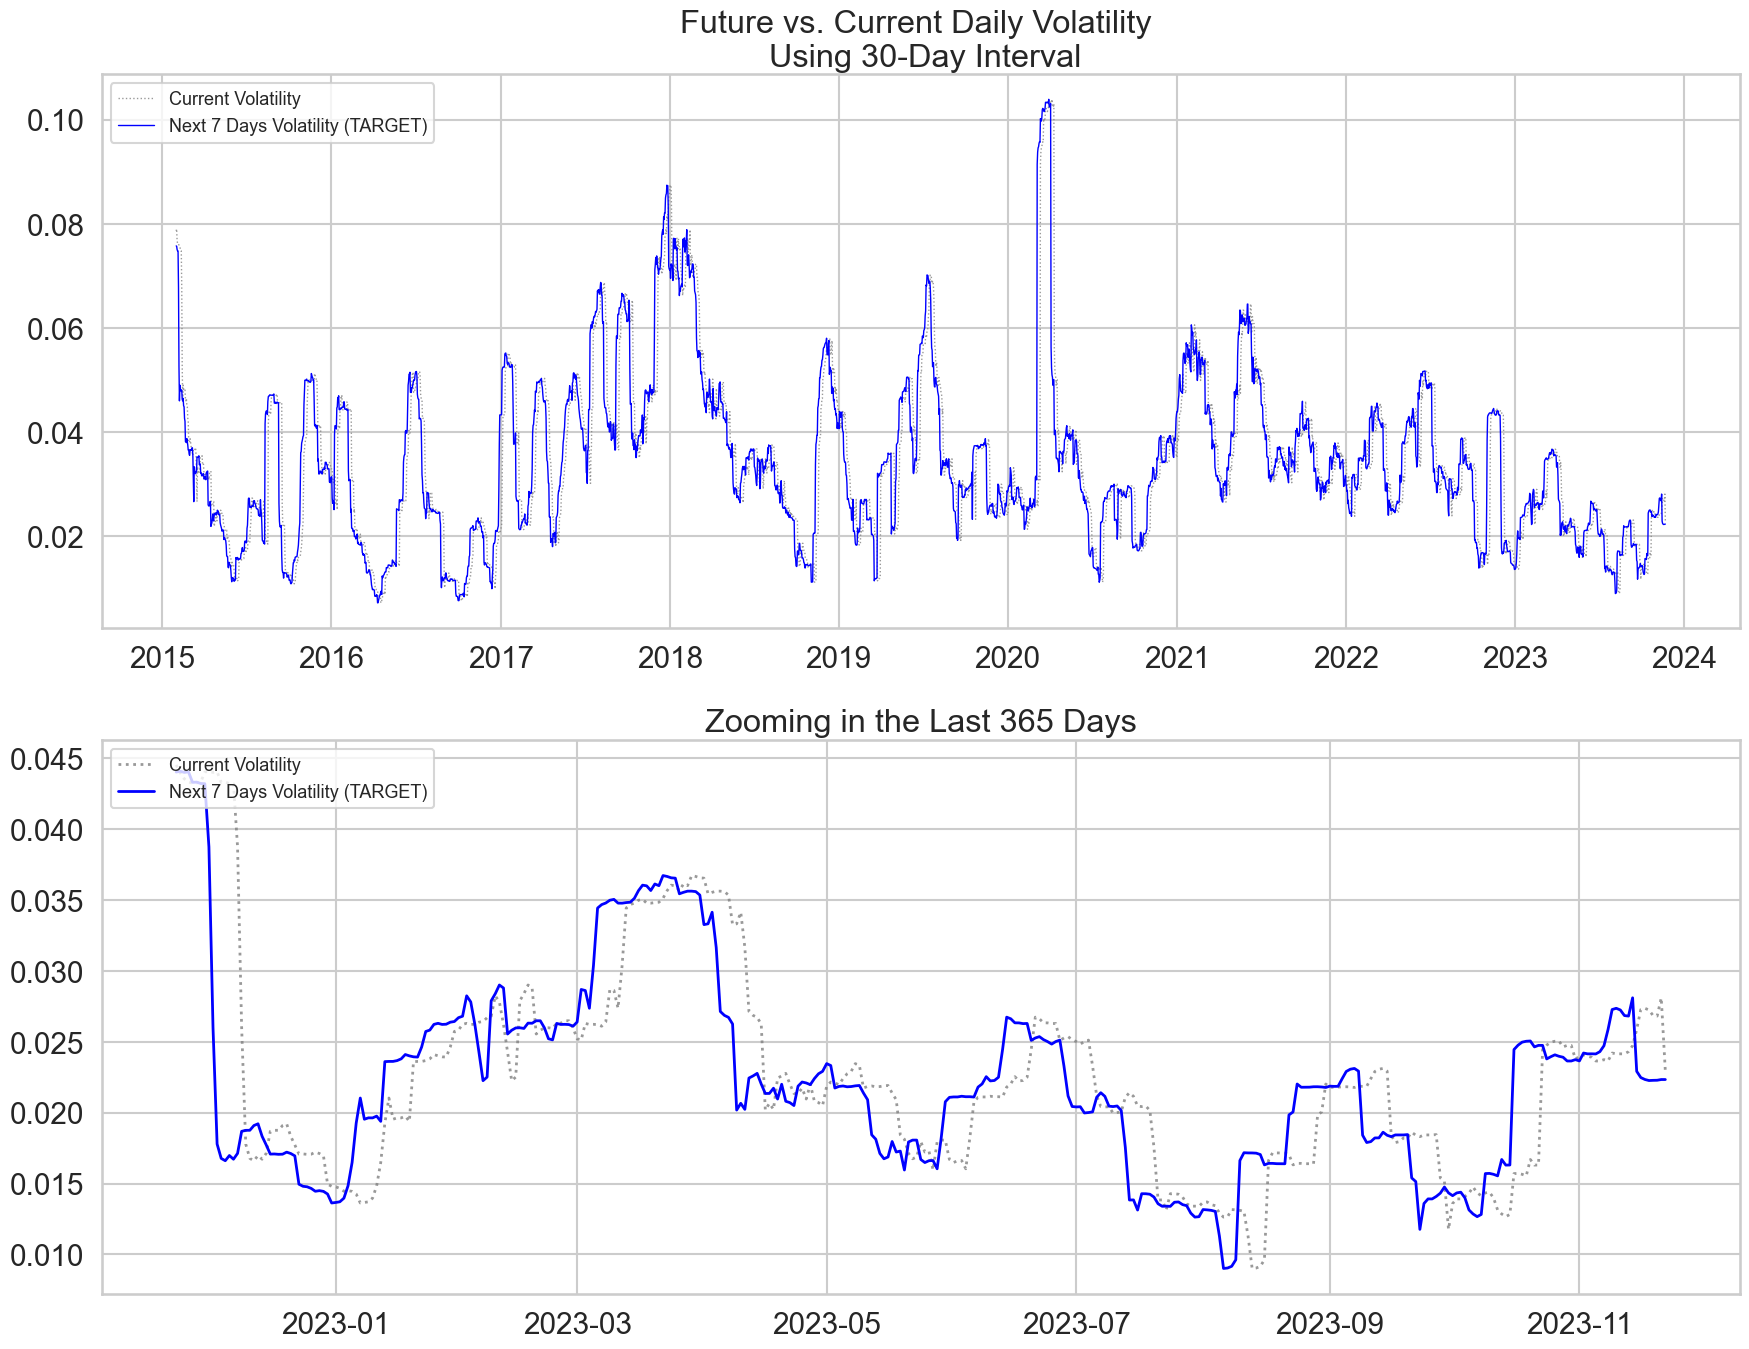

In [29]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'daily_vol.jpg'), 
                dpi=300, bbox_inches='tight')
    plt.show();

### **Daily Volatility Grouped by Month**

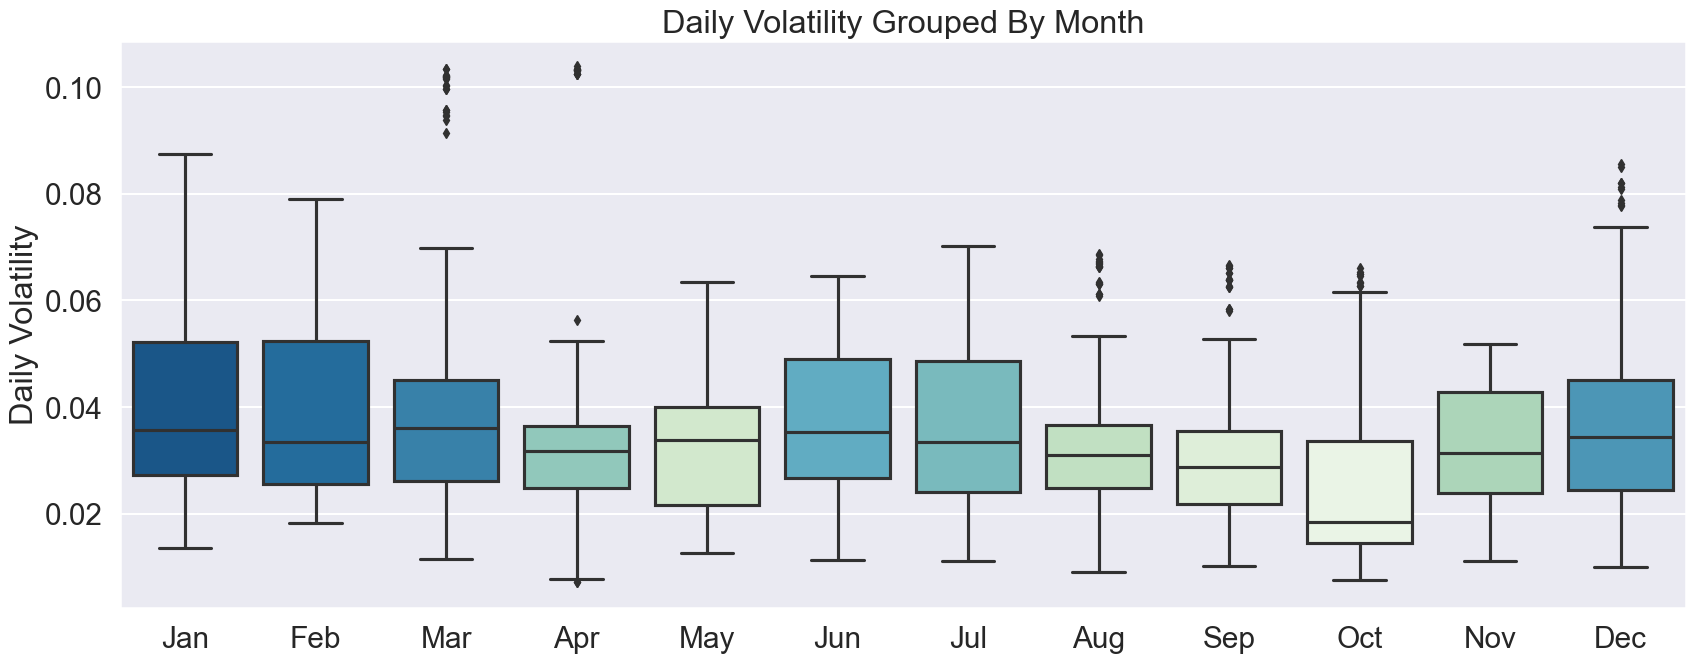

In [30]:
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

data.index = [x[:3] for x in data.index]

pal = sns.color_palette("GnBu", len(data))

rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    plt.savefig(os.path.join(directory_to_img, "vol_by_month.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03

### **Daily Volatility Grouped by Year**

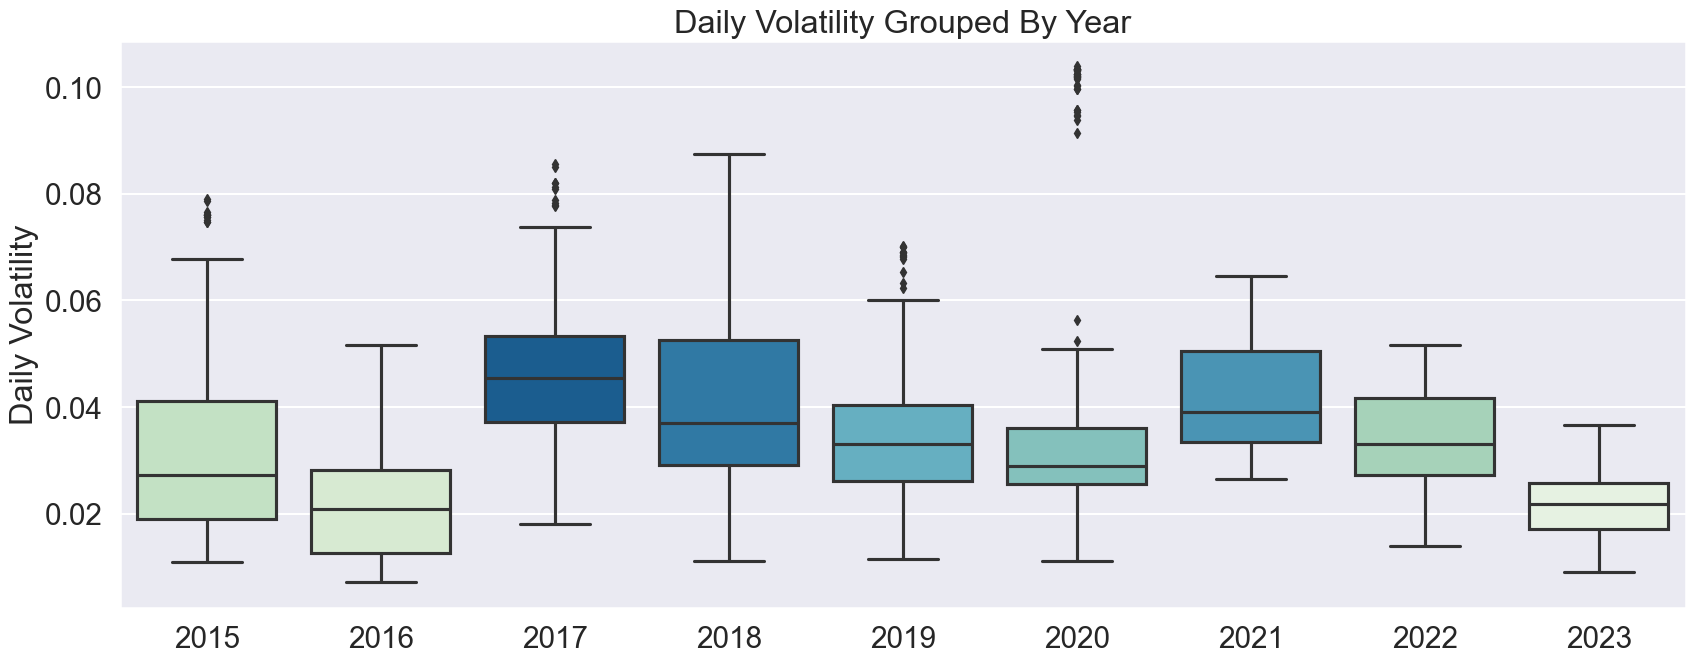

In [32]:
data = df.groupby(by=[df.index.year]).vol_current.mean()
pal = sns.color_palette("GnBu", len(data))
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.savefig(os.path.join(directory_to_img, "vol_by_year.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()

### **Daily Volatility Distribution**

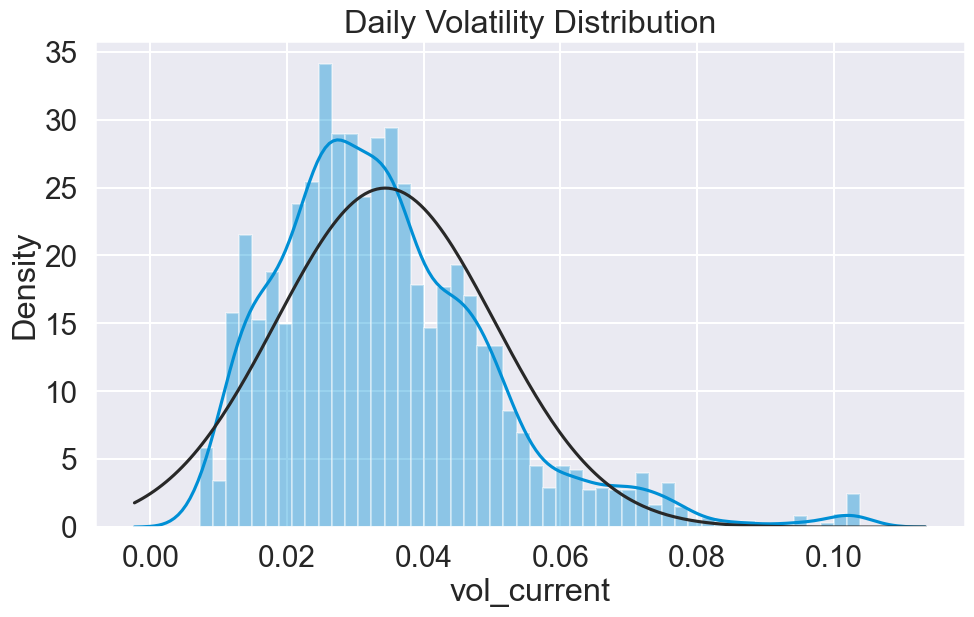

In [33]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

### **Returns/Log Returns Stationarity Checking**



In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -58.15183104523561
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8624
10%: -2.5672


In [36]:
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -58.05564026193788
p-value: 0.0
Critical Values:
1%: -3.4324
5%: -2.8624
10%: -2.5672


## Train-Validation-Test Splits

In [37]:
test_size = 30
val_size = 365

split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [38]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2015-01-31 00:00:00+00:00 	to: 2022-10-23 00:00:00+00:00 	2823 days
VALIDATION 	From: 2022-10-24 00:00:00+00:00 	to: 2023-10-23 00:00:00+00:00 	365 days
TEST 		From: 2023-10-24 00:00:00+00:00 	to: 2023-11-22 00:00:00+00:00 	30 days


In [39]:
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [40]:
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [41]:
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [42]:
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [43]:
y_train.describe()

count    2823.000000
mean        0.035830
std         0.016074
min         0.007228
25%         0.025278
50%         0.033742
75%         0.044677
max         0.103878
Name: vol_future, dtype: float64

In [44]:
x_train.describe()

count    2823.000000
mean        0.035981
std         0.016173
min         0.007228
25%         0.025348
50%         0.033773
75%         0.044779
max         0.103878
Name: vol_current, dtype: float64

## **Data Preprocessing**

### 1. Feature Normalization

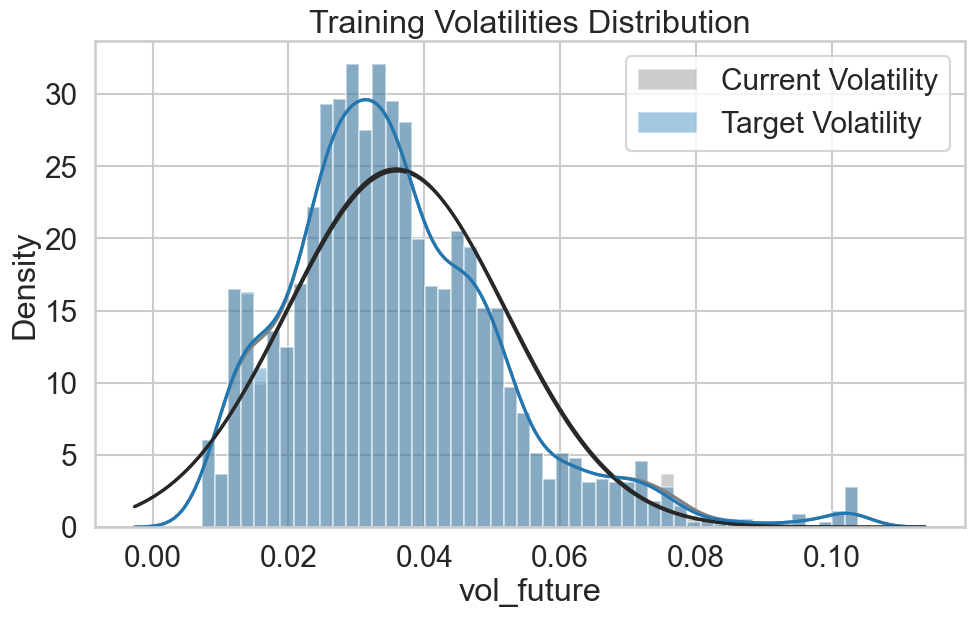

In [45]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [47]:
def transform_volatility_to_scaler(scaler, tf_series):
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [48]:
scaler_vol = MinMaxScaler()
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [49]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [50]:
x_train.head(10)

Date
2015-01-31 00:00:00+00:00    0.078597
2015-02-01 00:00:00+00:00    0.078996
2015-02-02 00:00:00+00:00    0.076635
2015-02-03 00:00:00+00:00    0.076269
2015-02-04 00:00:00+00:00    0.075940
2015-02-05 00:00:00+00:00    0.075981
2015-02-06 00:00:00+00:00    0.075927
2015-02-07 00:00:00+00:00    0.075733
2015-02-08 00:00:00+00:00    0.075679
2015-02-09 00:00:00+00:00    0.075032
Name: vol_current, dtype: float64

In [51]:
y_train.head(10)

Date
2015-01-31 00:00:00+00:00    0.075733
2015-02-01 00:00:00+00:00    0.075679
2015-02-02 00:00:00+00:00    0.075032
2015-02-03 00:00:00+00:00    0.074769
2015-02-04 00:00:00+00:00    0.074756
2015-02-05 00:00:00+00:00    0.067772
2015-02-06 00:00:00+00:00    0.052634
2015-02-07 00:00:00+00:00    0.045995
2015-02-08 00:00:00+00:00    0.049007
2015-02-09 00:00:00+00:00    0.048346
Name: vol_future, dtype: float64

In [52]:
x_train_scaled.head(10)

Date
2015-01-31 00:00:00+00:00    0.738427
2015-02-01 00:00:00+00:00    0.742558
2015-02-02 00:00:00+00:00    0.718122
2015-02-03 00:00:00+00:00    0.714342
2015-02-04 00:00:00+00:00    0.710934
2015-02-05 00:00:00+00:00    0.711357
2015-02-06 00:00:00+00:00    0.710799
2015-02-07 00:00:00+00:00    0.708793
2015-02-08 00:00:00+00:00    0.708239
2015-02-09 00:00:00+00:00    0.701536
dtype: float64

In [53]:
y_train_scaled.head(10)

Date
2015-01-31 00:00:00+00:00    0.708793
2015-02-01 00:00:00+00:00    0.708239
2015-02-02 00:00:00+00:00    0.701536
2015-02-03 00:00:00+00:00    0.698817
2015-02-04 00:00:00+00:00    0.698685
2015-02-05 00:00:00+00:00    0.626423
2015-02-06 00:00:00+00:00    0.469793
2015-02-07 00:00:00+00:00    0.401100
2015-02-08 00:00:00+00:00    0.432268
2015-02-09 00:00:00+00:00    0.425432
dtype: float64

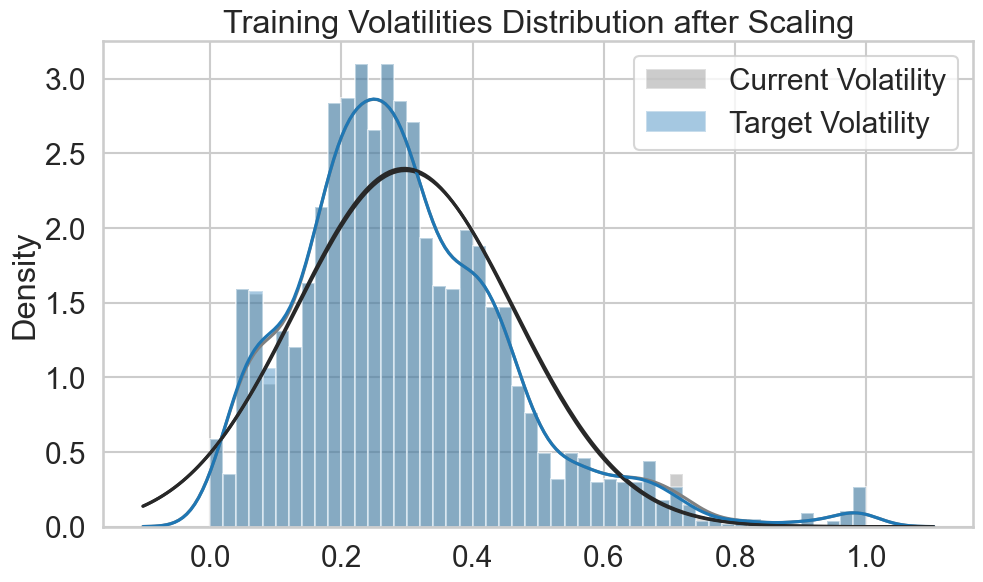

In [54]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.savefig(os.path.join(directory_to_img, "vol_dist.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

### 2. Train-Validation-Test Visualization

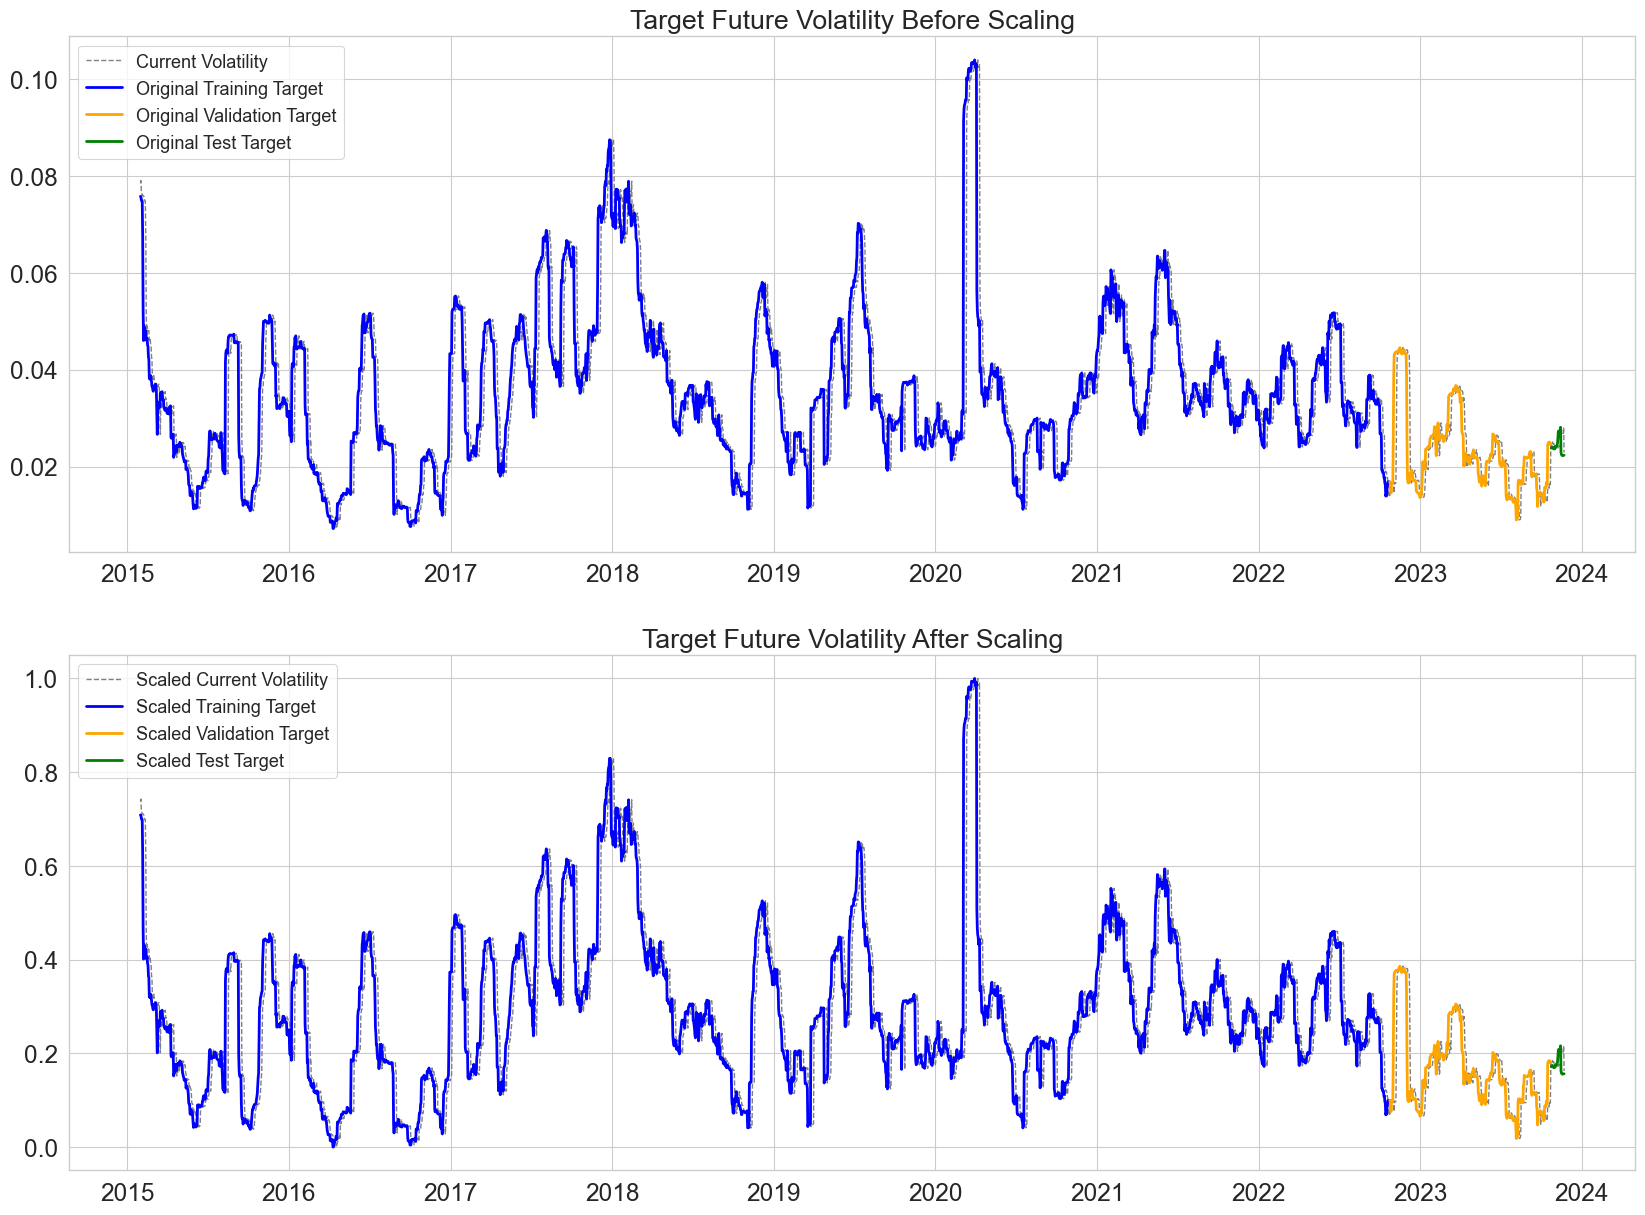

In [55]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.savefig(os.path.join(directory_to_img, 'train_val_test_org_scled.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

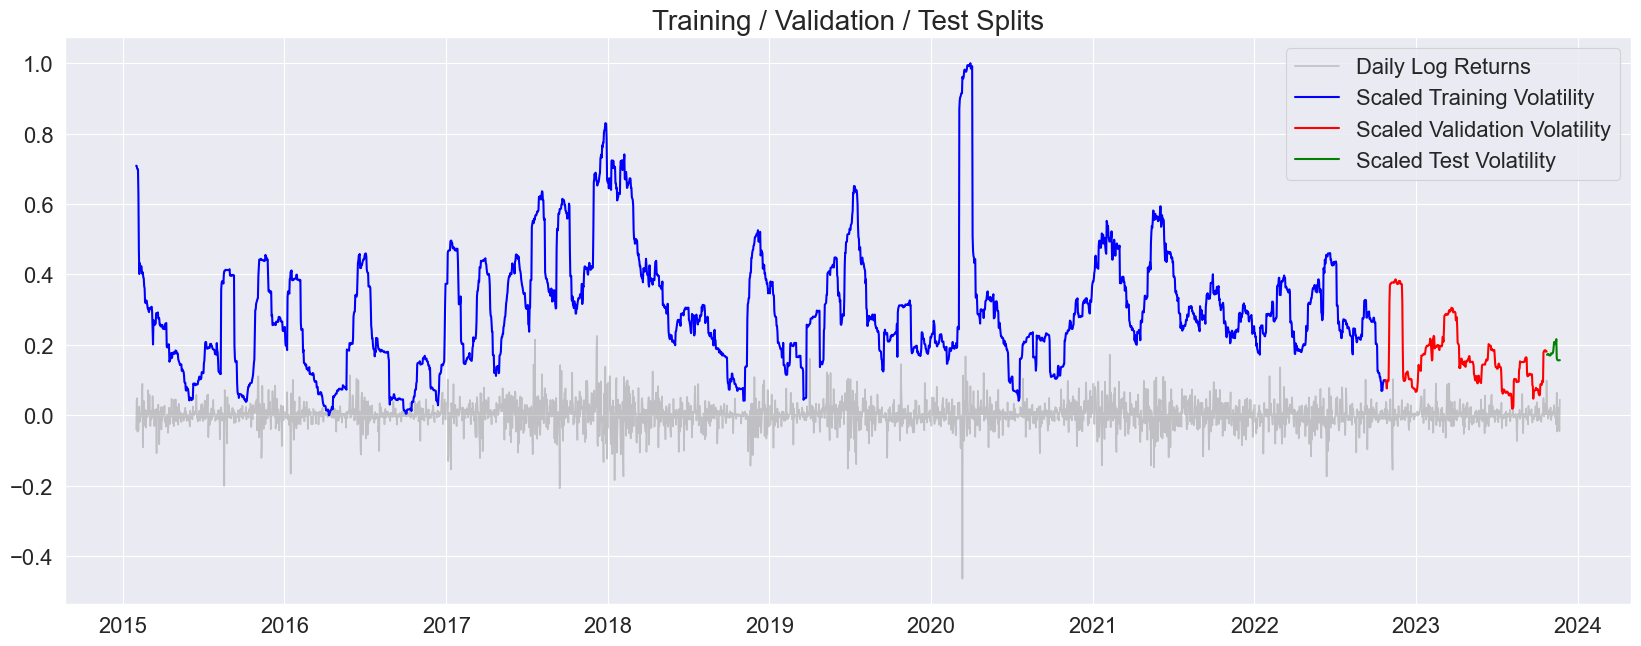

In [56]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.savefig(os.path.join(directory_to_img, 'train_val_test.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

# MODELING

## 1. Performance Metrics

In [57]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [58]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [59]:
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [60]:
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [61]:
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 2. Baseline Models

### 2.1. Mean Baseline

In [62]:
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.29748959081759213

In [63]:
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

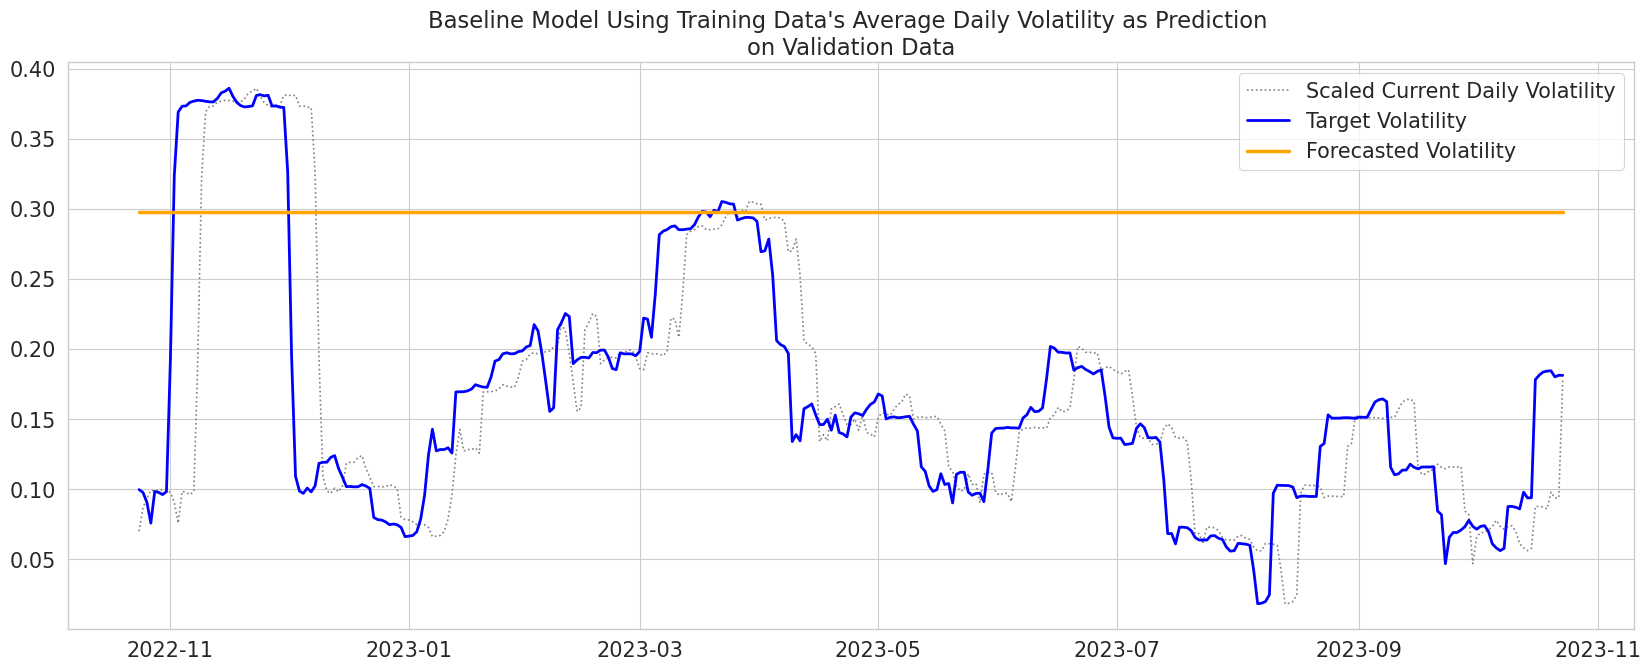

In [64]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig(os.path.join(directory_to_img, 'baseline.jpg'), dpi=300, bbox_inches='tight')
plt.show();

In [65]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline           2.25406         0.158991

### 2.2. Random Walk Naive Forecasting

In [66]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

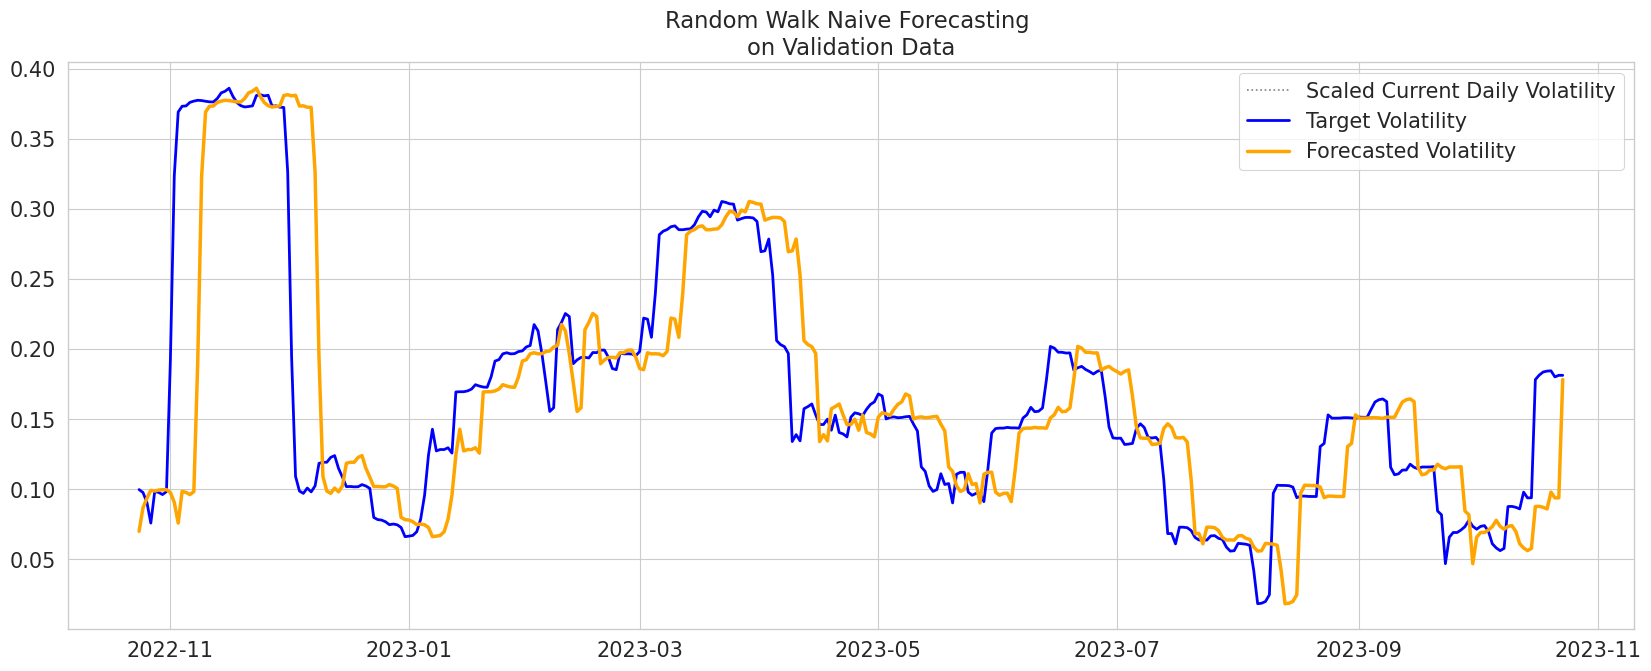

In [67]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig(os.path.join(directory_to_img, 'naive.jpg'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [68]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

Model  Validation RMSPE  Validation RMSE
0                  Mean Baseline          2.254060         0.158991
1  Random Walk Naive Forecasting          0.504028         0.062188

## 3. GARCH Models

### 3.1. Basic GARCH

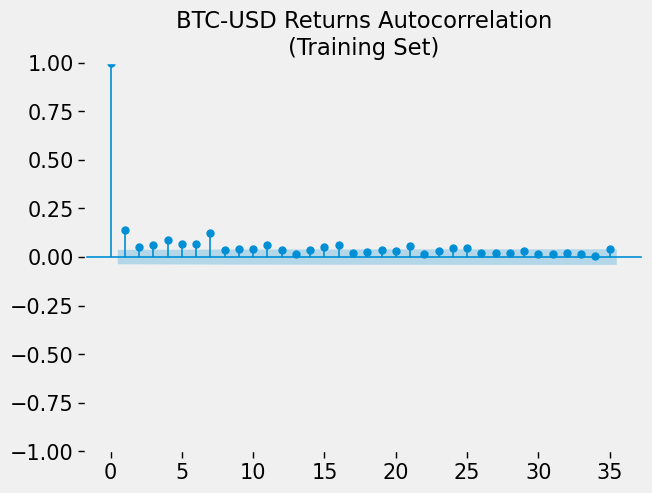

In [69]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

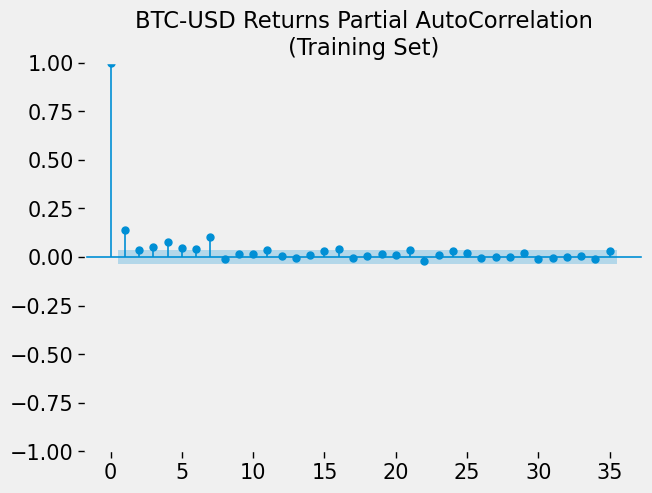

In [70]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [71]:
from arch import arch_model

In [72]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7546.11
Distribution:                  Normal   AIC:                           15124.2
Method:            Maximum Likelihood   BIC:                           15219.3
                                        No. Observations:                 2823
Date:                Thu, Dec 14 2023   Df Residuals:                     2822
Time:                        15:54:53   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2201  5.866e-02      3.752  1.753e-04 [  0.105,  0.3

In [73]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7564.76
Distribution:                  Normal   AIC:                           15137.5
Method:            Maximum Likelihood   BIC:                           15161.3
                                        No. Observations:                 2823
Date:                Thu, Dec 14 2023   Df Residuals:                     2822
Time:                        15:54:59   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2225  6.021e-02      3.696  2.193e-04 [  0.105,  0.3

In [74]:
def scale_tf_cond_vol(model_result):
    cond_vol = model_result.conditional_volatility

    scaler = MinMaxScaler()
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [76]:
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [77]:
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

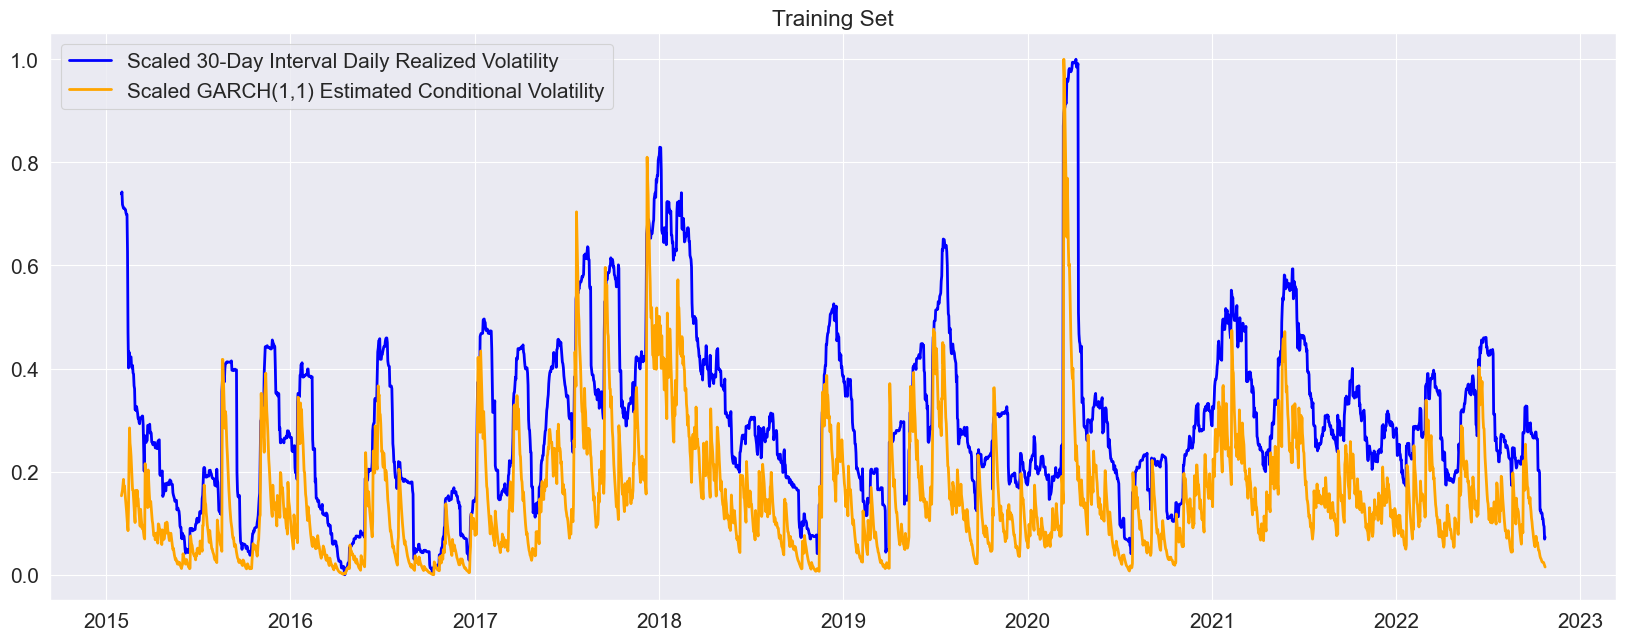

In [78]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### 3.1.1. Analytical-based Forecasting

In [79]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [80]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

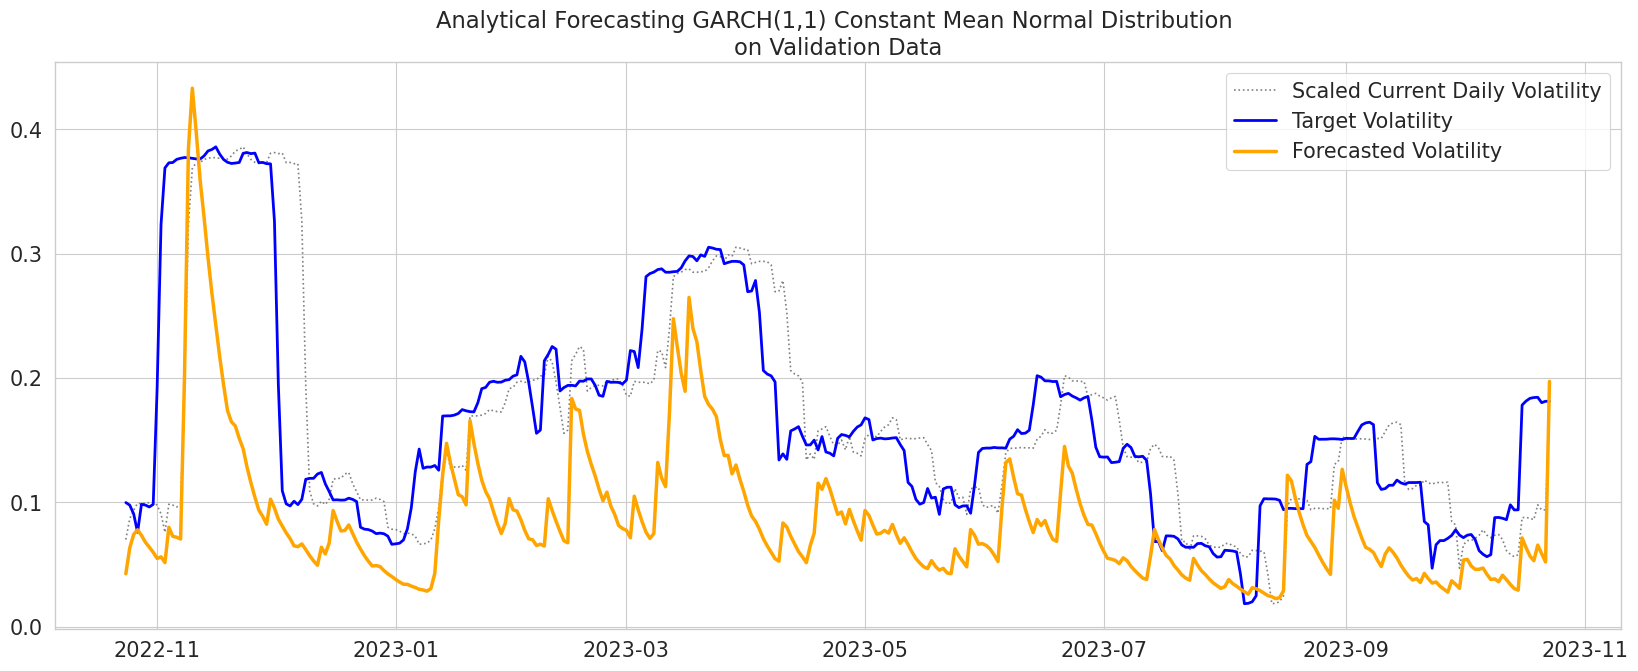

In [81]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [82]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          2.254060         0.158991
1           Random Walk Naive Forecasting          0.504028         0.062188
2  GARCH(1,1), Constant Mean, Normal Dist          0.506356         0.101584

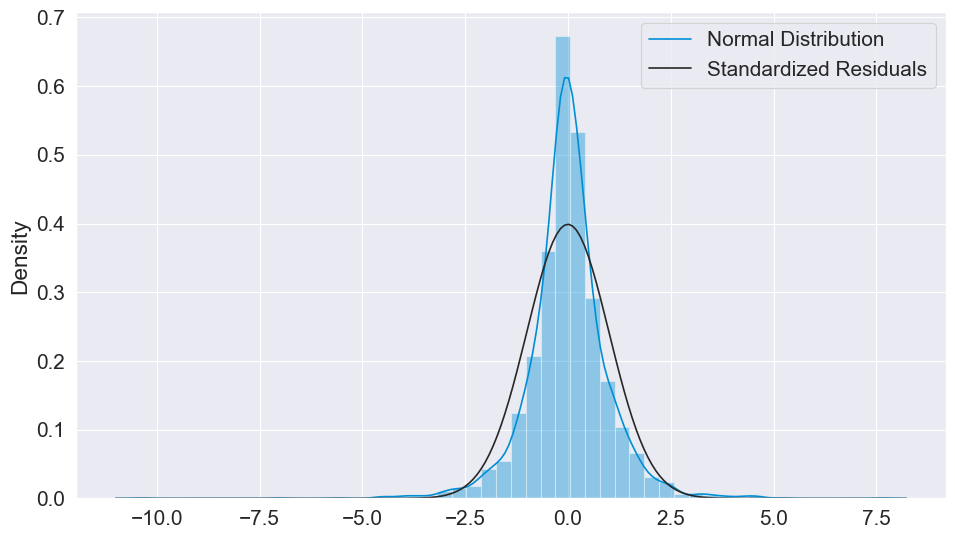

In [83]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

### 3.2. GARCH Model with Asymmetric Shocks Responses

In [84]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7187.33
Distribution:      Standardized Skew Student's t   AIC:                           14388.7
Method:                       Maximum Likelihood   BIC:                           14430.3
                                                   No. Observations:                 2823
Date:                           Thu, Dec 14 2023   Df Residuals:                     2822
Time:                                   15:55:51   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [85]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

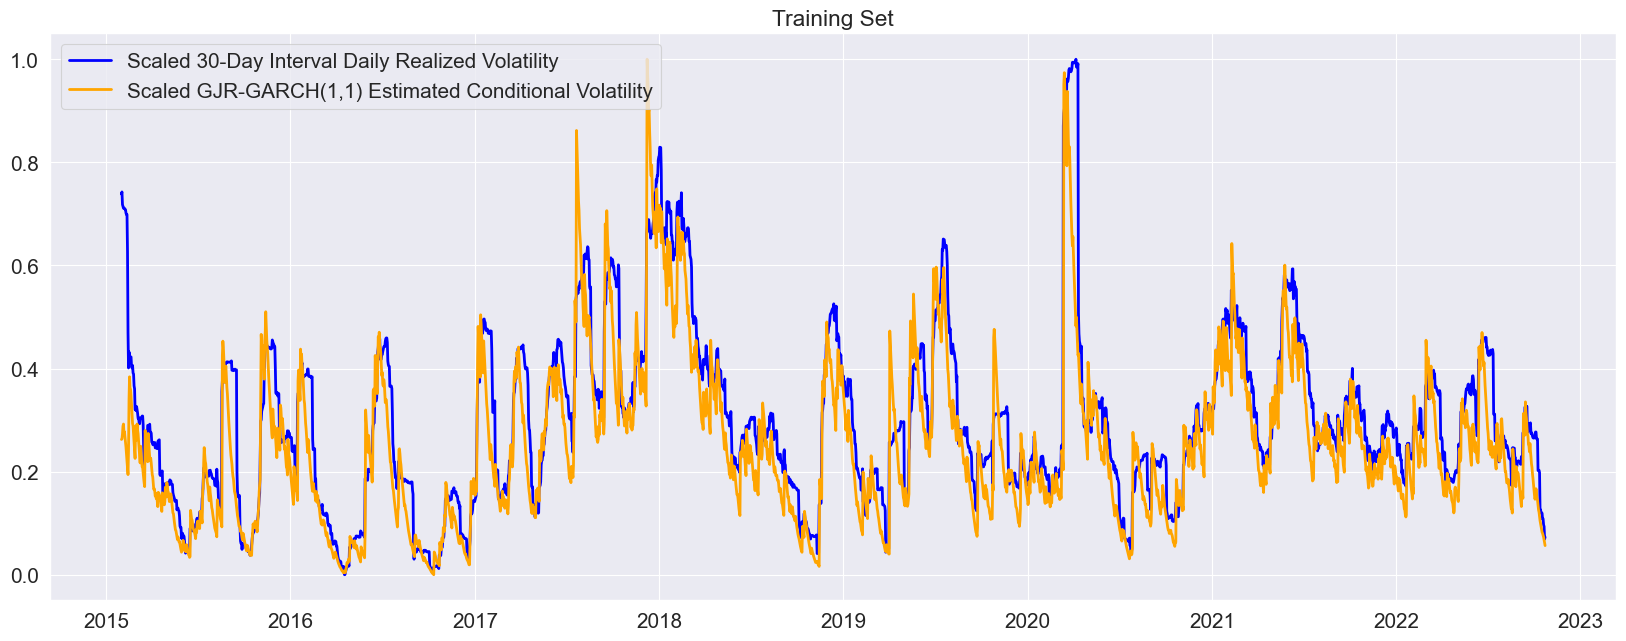

In [86]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [87]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [88]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

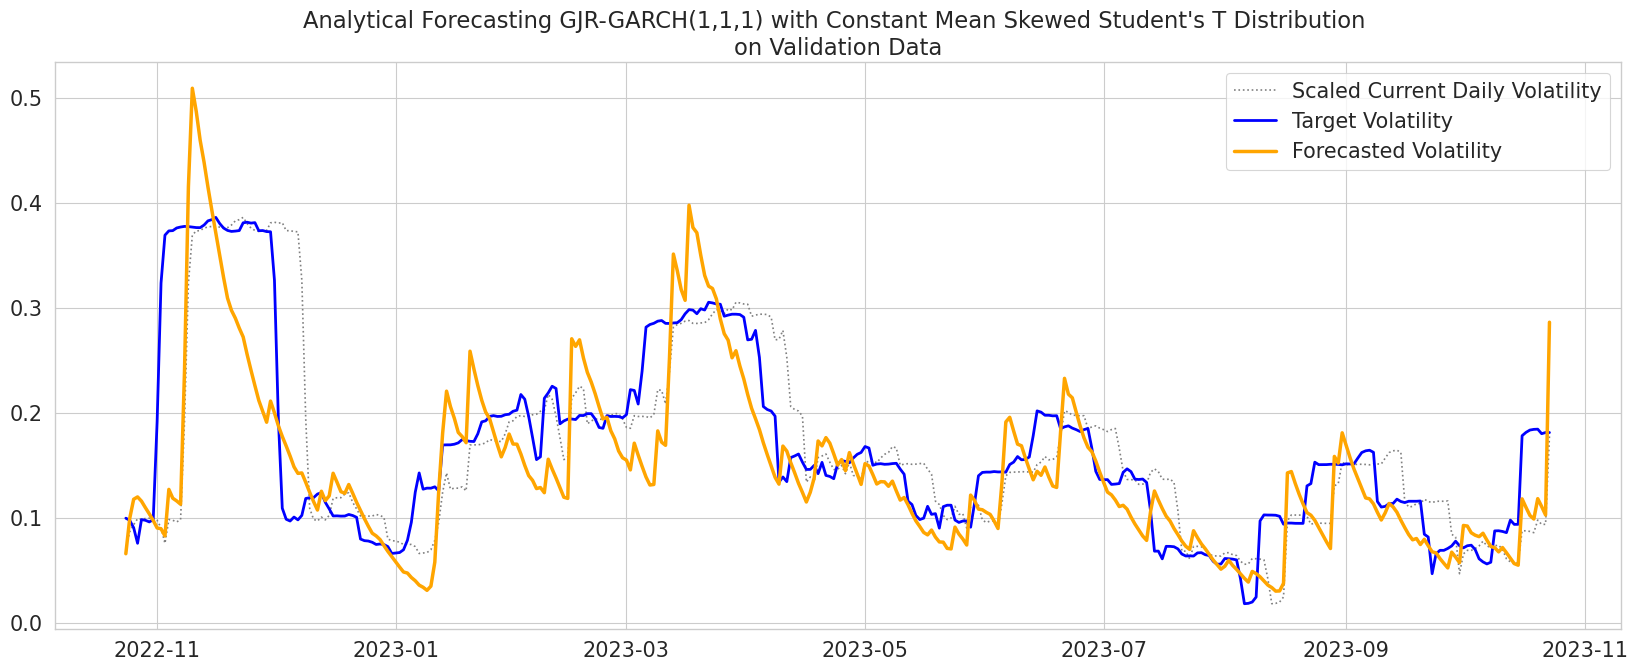

In [89]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")

In [90]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217

### 3.3. TARCH

In [91]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7187.32
Distribution:      Standardized Skew Student's t   AIC:                           14388.6
Method:                       Maximum Likelihood   BIC:                           14430.3
                                                   No. Observations:                 2823
Date:                           Thu, Dec 14 2023   Df Residuals:                     2822
Time:                                   15:56:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [92]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

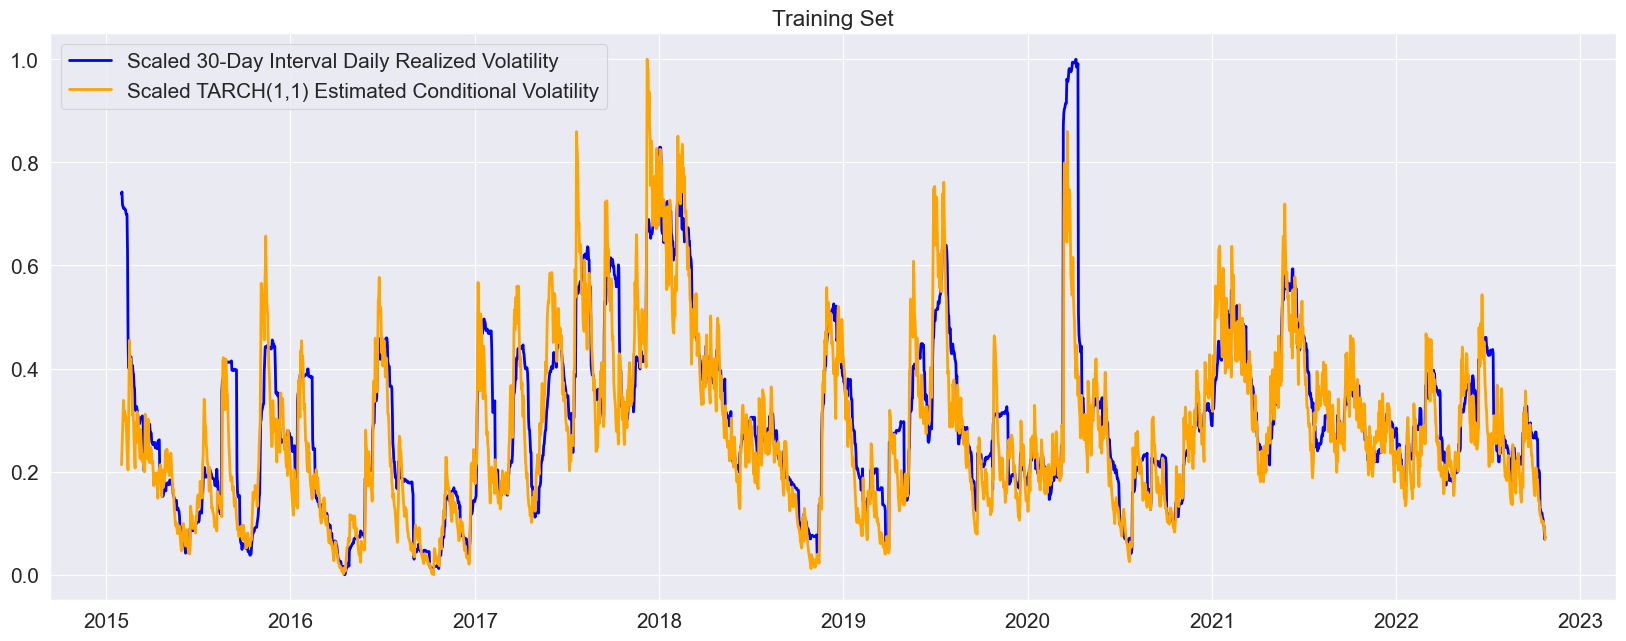

In [93]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

#### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

In [94]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize

In [95]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

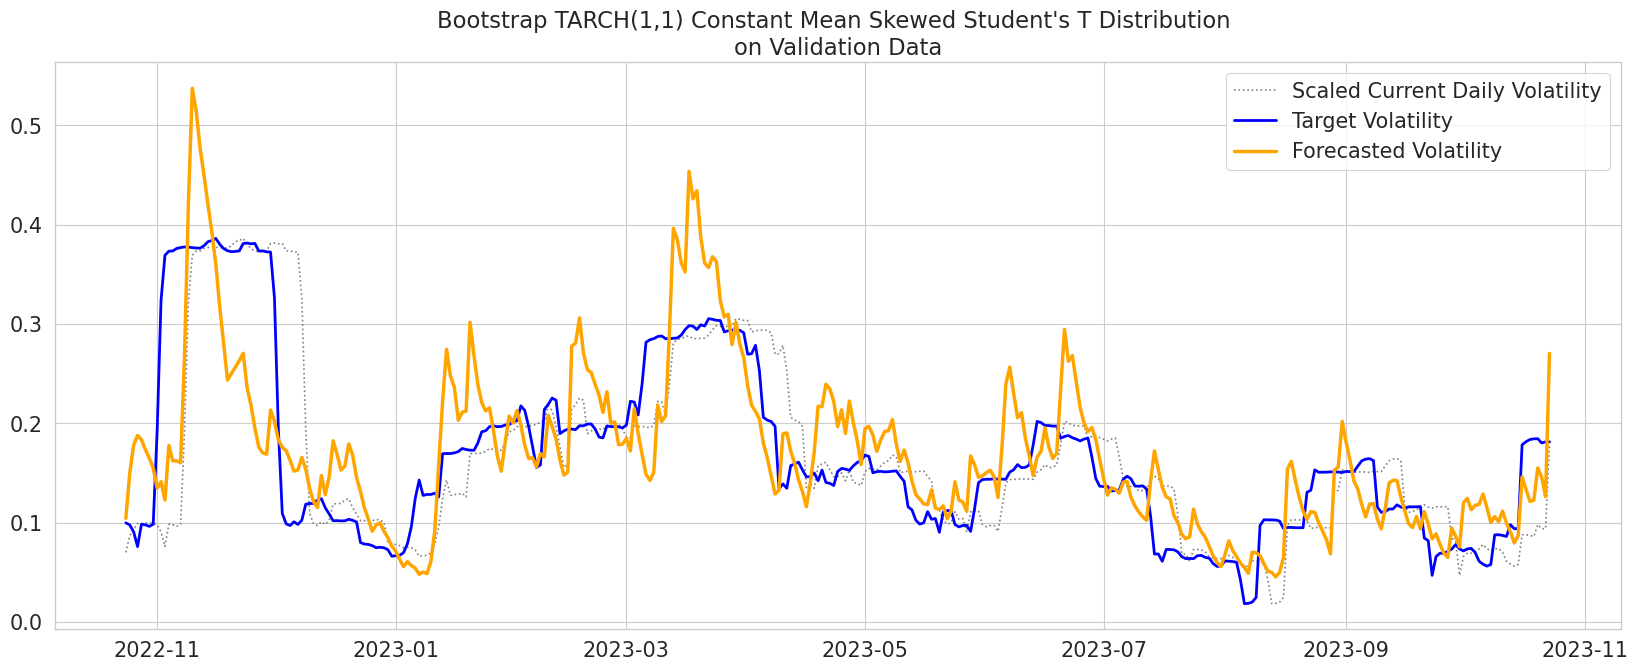

In [96]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [97]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662

#### 3.3.2. Simulation-based Forecasting for TARCH(1,1)



In [98]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize

In [99]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

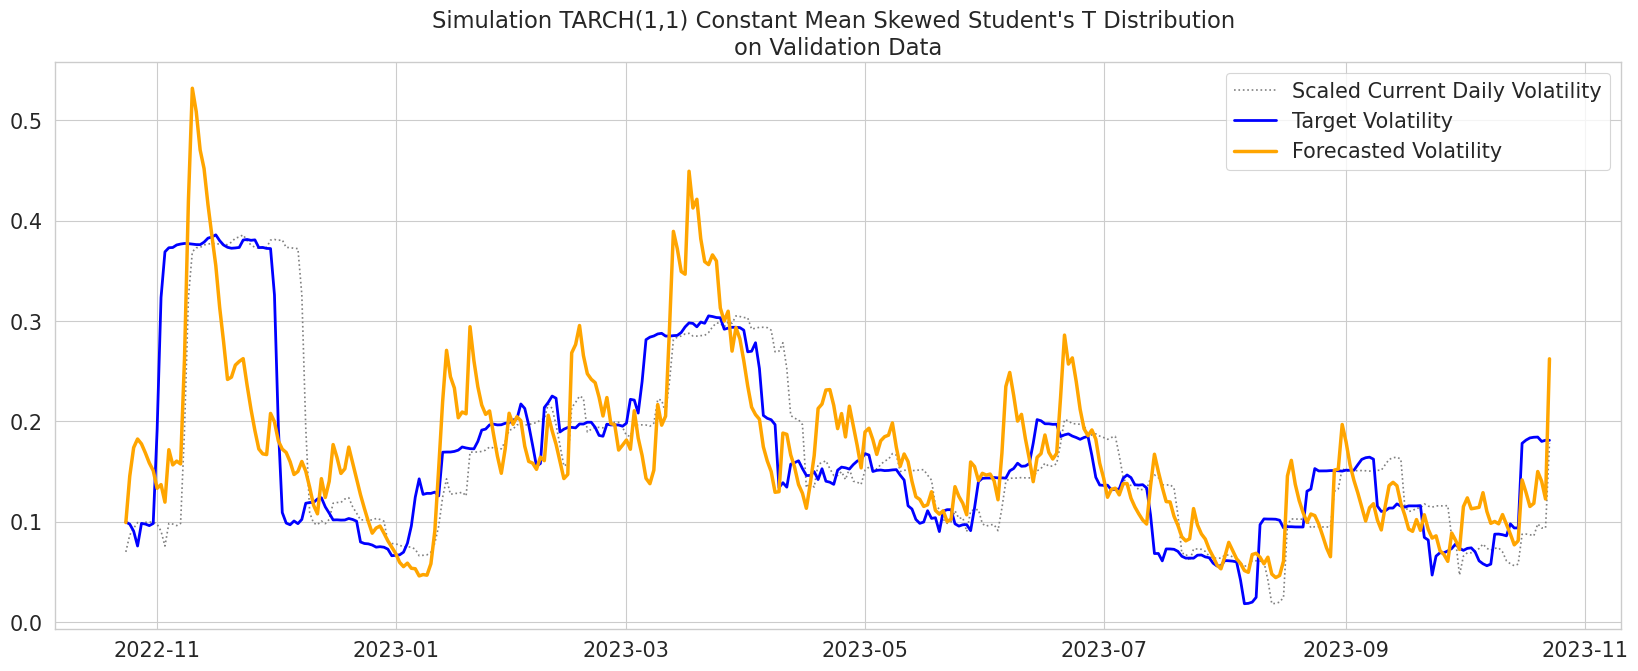

In [100]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [101]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.421078   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662  
5         0.062941

#### 3.3.3. Hyperparameter Tuning for TARCH

In [102]:
import itertools

In [103]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize

In [104]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.40903336437894317 using TARCH(1, 2, 2)


In [105]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

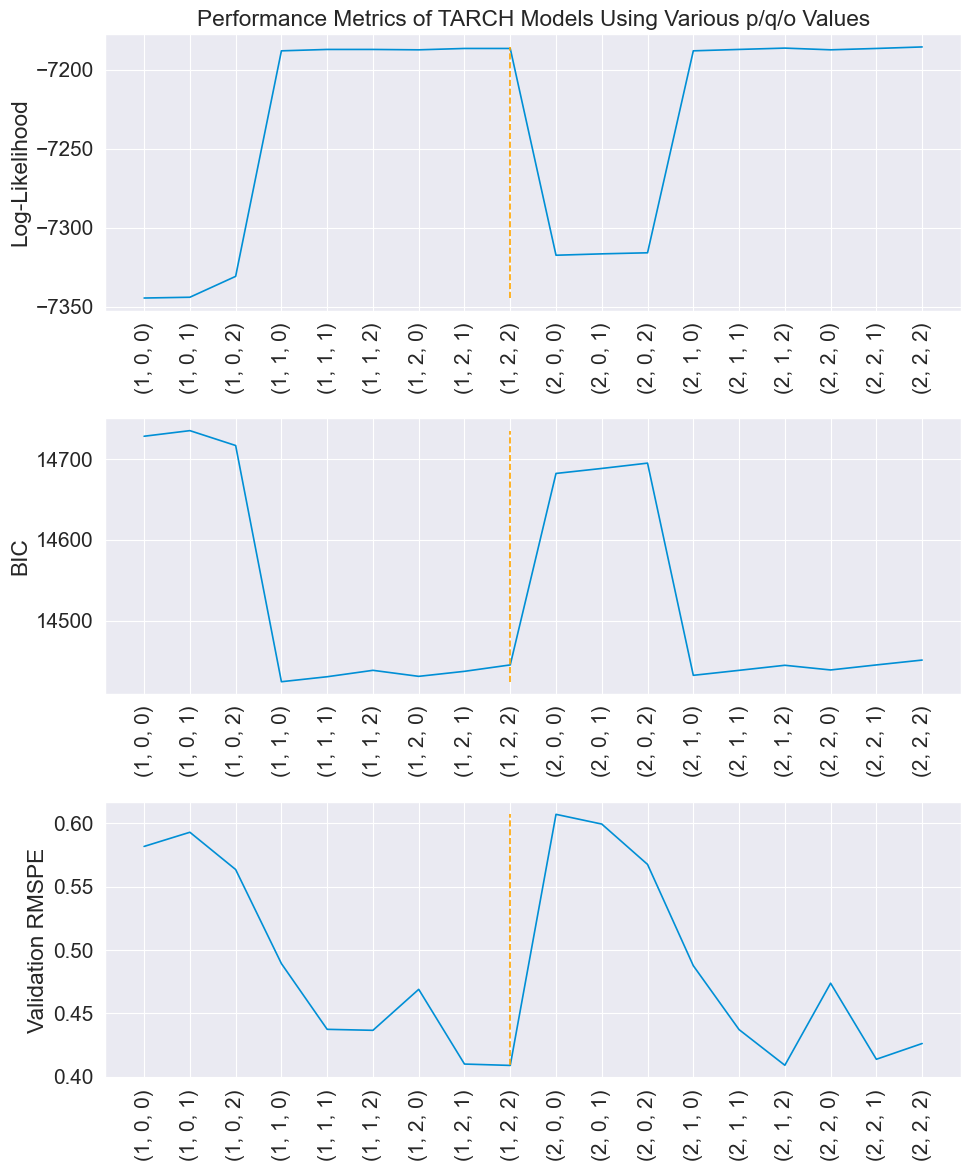

In [106]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    

### 3.4. Final GARCH Model - TARCH(1,2)

In [107]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -7186.70
Distribution:      Standardized Skew Student's t   AIC:                           14391.4
Method:                       Maximum Likelihood   BIC:                           14444.9
                                                   No. Observations:                 2823
Date:                           Thu, Dec 14 2023   Df Residuals:                     2822
Time:                                   16:01:57   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [108]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

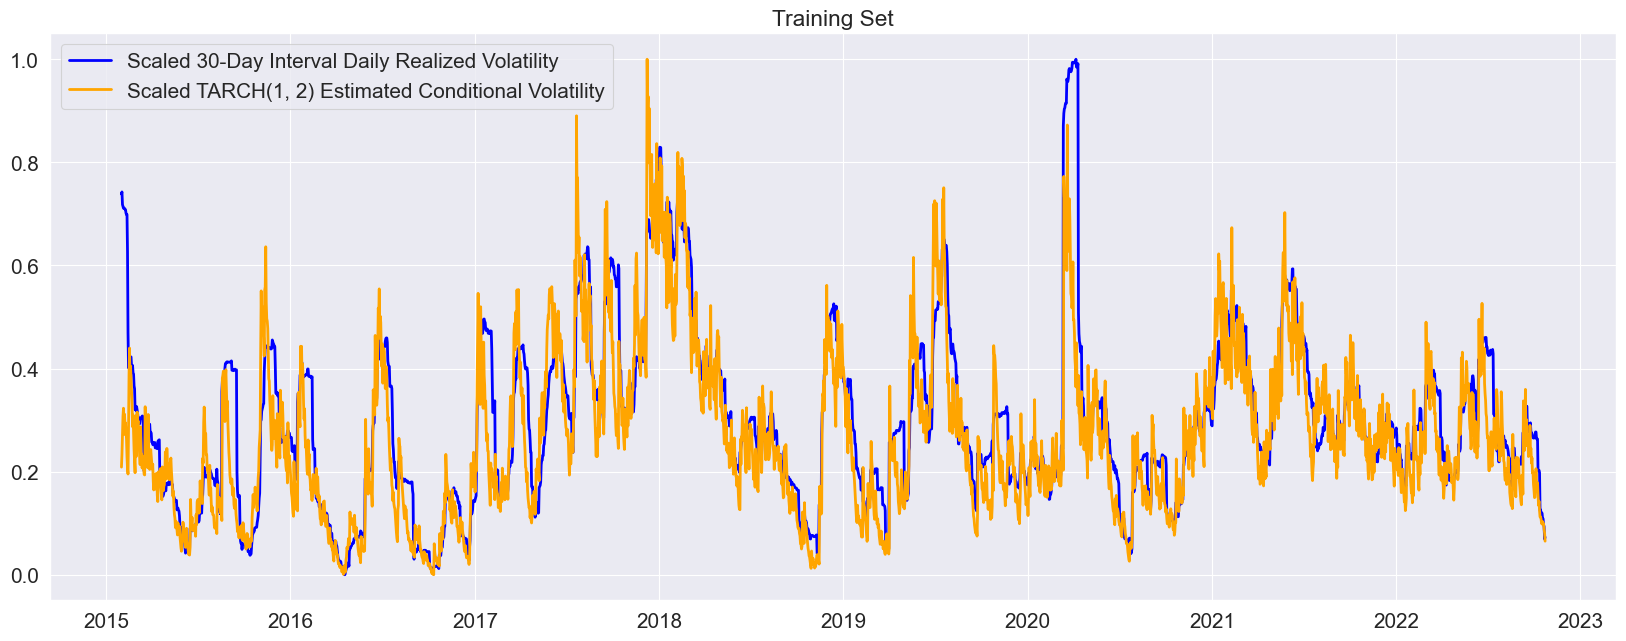

In [109]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')

In [110]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize

In [111]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

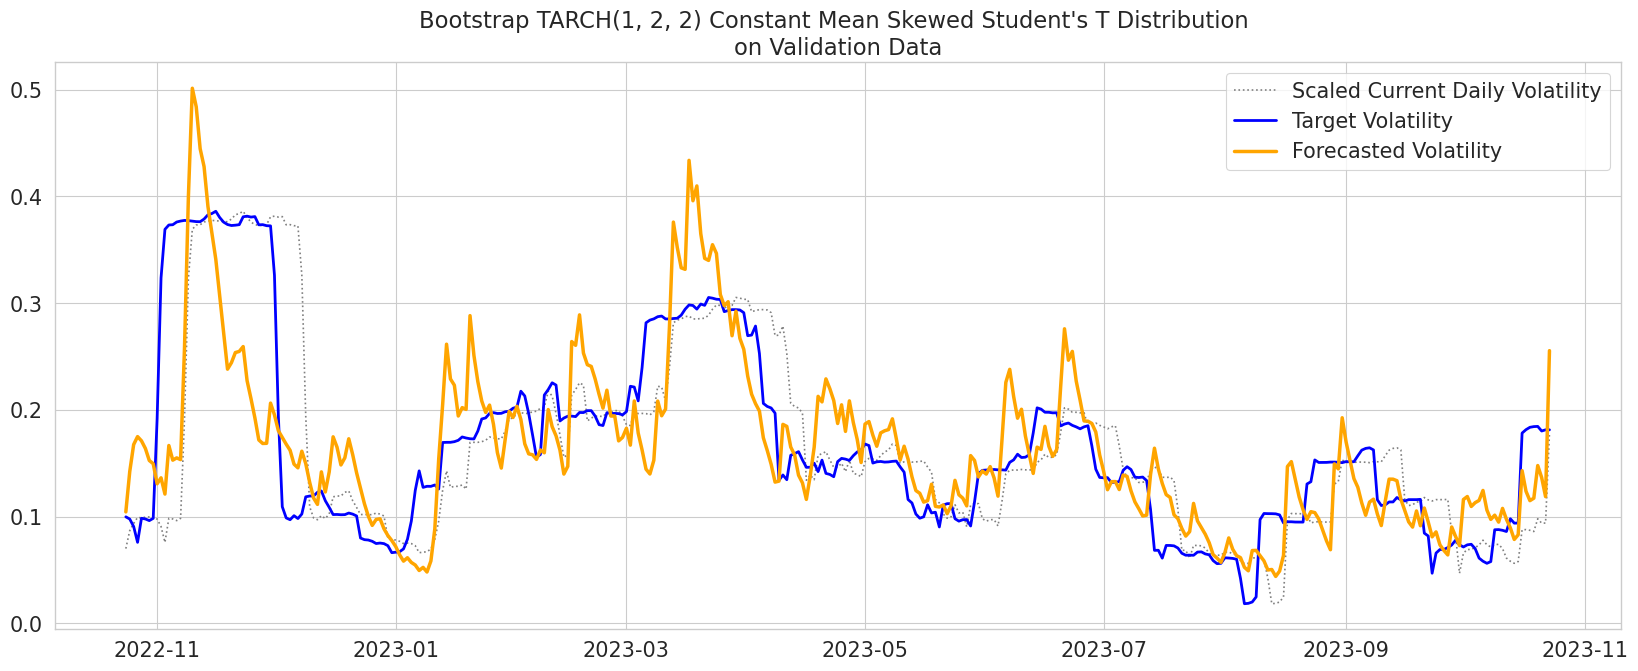

In [112]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.savefig(os.path.join(directory_to_img, 'best_tarch_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [113]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.421078   
6     Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist          0.409257   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662  
5         0.062941  
6         0.061094

## 4. Neural Networks

In [114]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [115]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [116]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [117]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [118]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [119]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.1. Neural Network Baseline Metrics - Fully Connected Network**

In [120]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [121]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

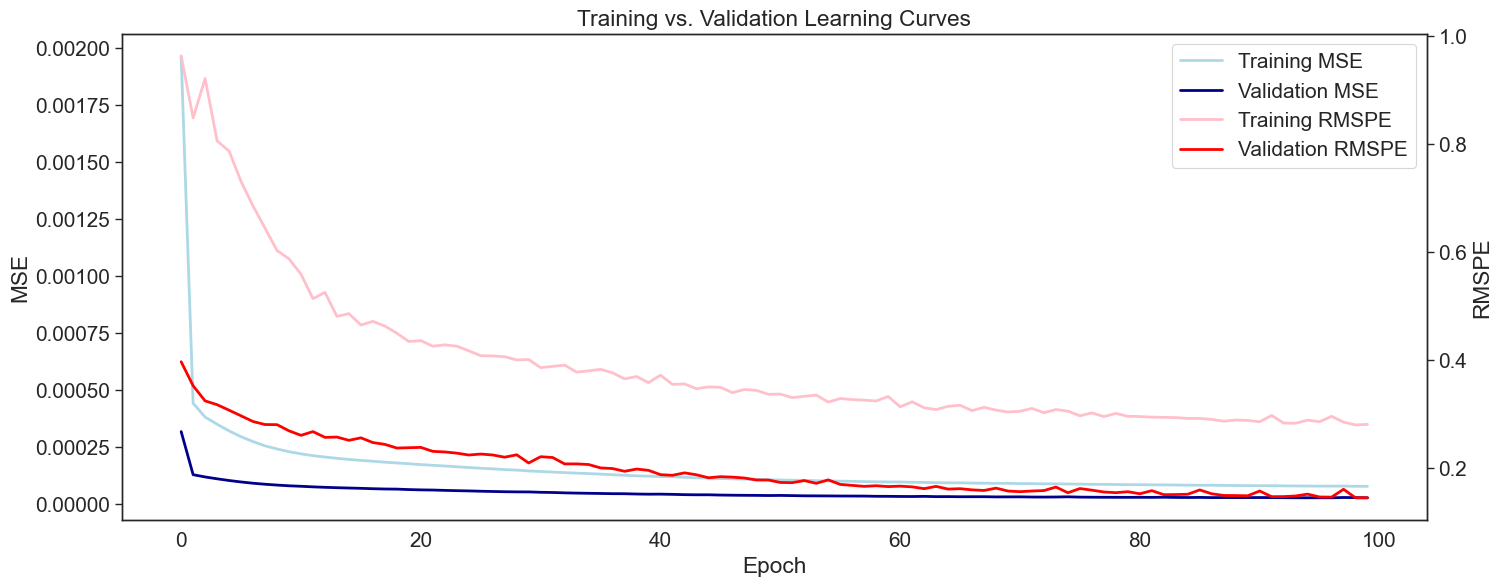

In [122]:
viz_train_val_metrics(snn_1_res)

In [123]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 355us/step


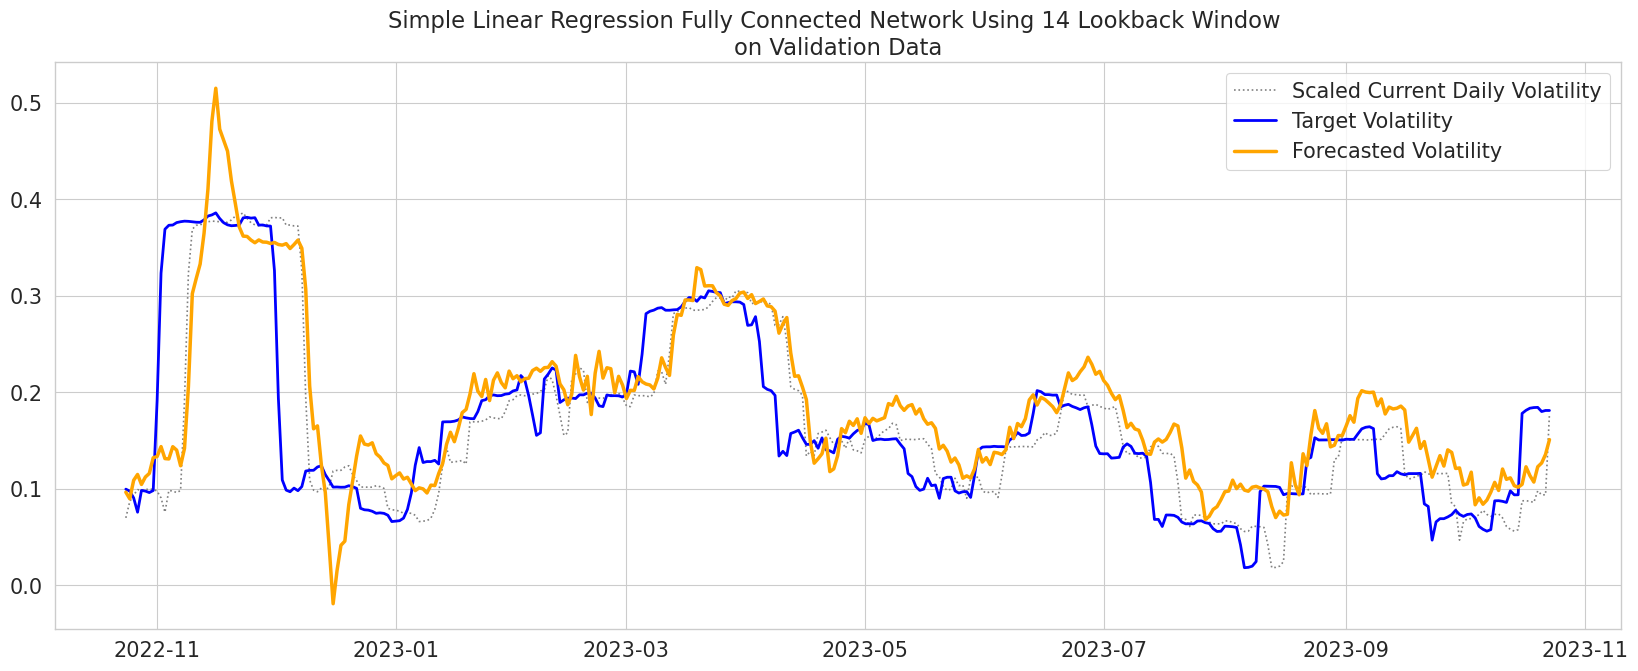

In [124]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          f"Simple Linear Regression Fully Connected Network Using {n_past} Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'fully_connected_NN.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [125]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.421078   
6     Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist          0.409257   
7                 Simple LR Fully Connected NN, n_past=14          0.679652   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662  
5         0.062941  
6         0.061094  
7         0.065121

### 4.2. Univariate Long Short-Term Memory (LSTM)**

In [126]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1781 (6.96 KB)
Trainable params: 1781 (6.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [127]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

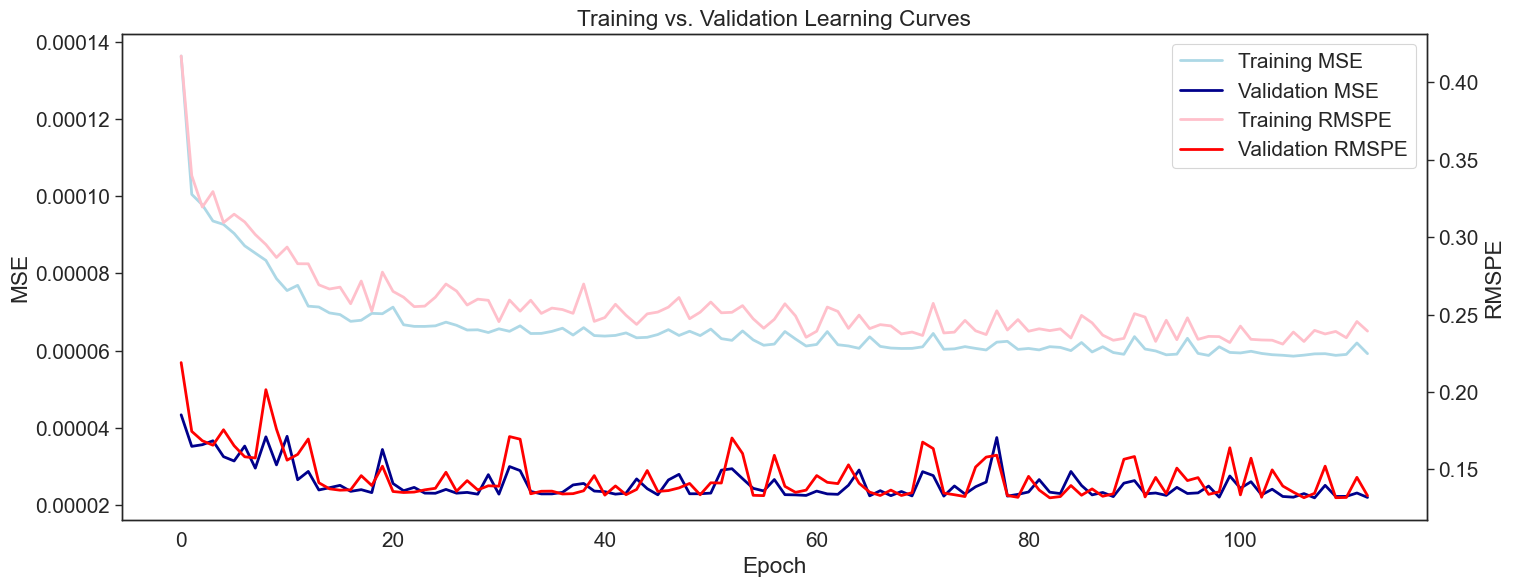

In [128]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

In [129]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 0s 763us/step


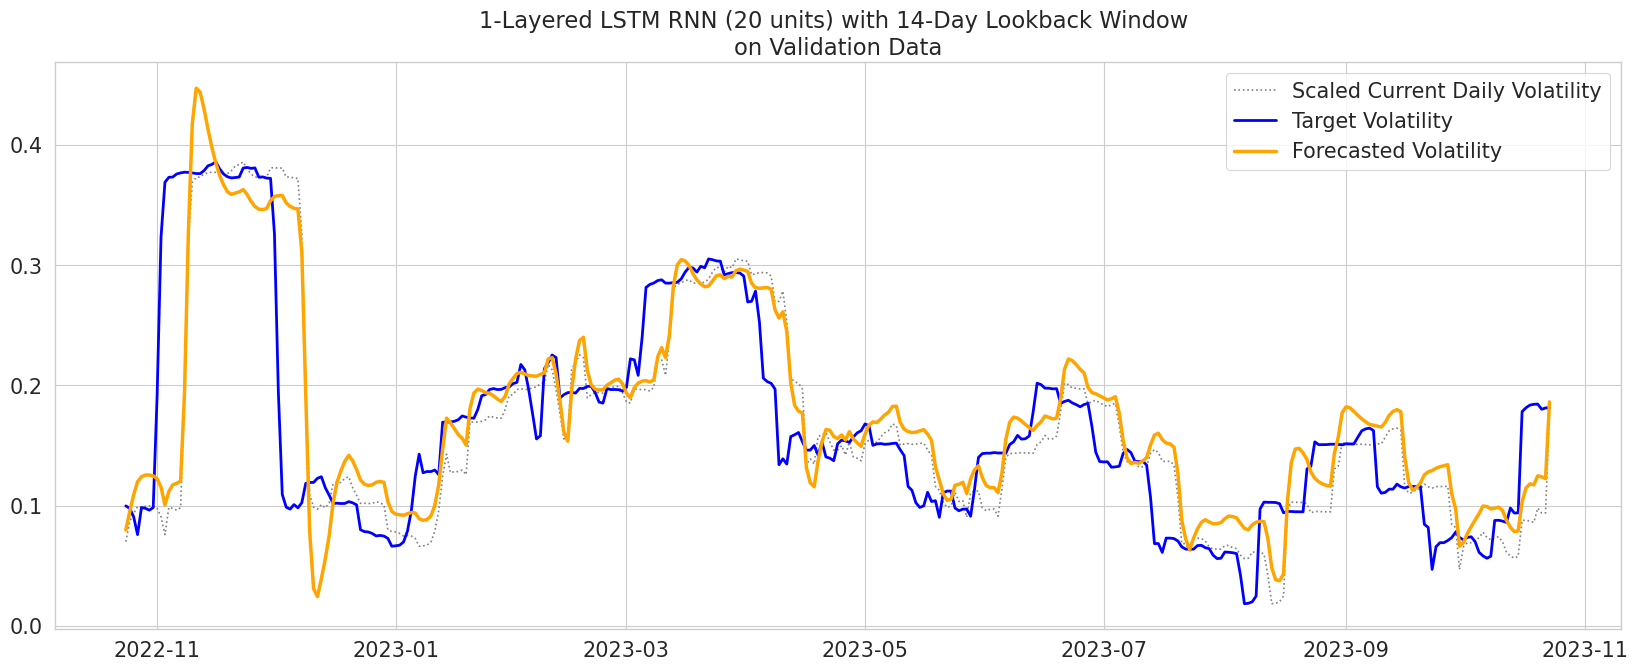

In [130]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_1.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [131]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.421078   
6     Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist          0.409257   
7                 Simple LR Fully Connected NN, n_past=14          0.679652   
8                        LSTM 1 layer 20 units, n_past=14          0.578908   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662  
5         0.062941  
6         0.061094  
7         0.065121  
8         0.059545

### 4.3. Univariate Bidirectional LSTM

In [132]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

# INCREASING LOOKBACK WINDOW TO 1 MONTH
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 19105 (74.63 KB)
Trainable params: 19105 (74.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [133]:
# FITTING lstm_2 TO TRAINING DATA
lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

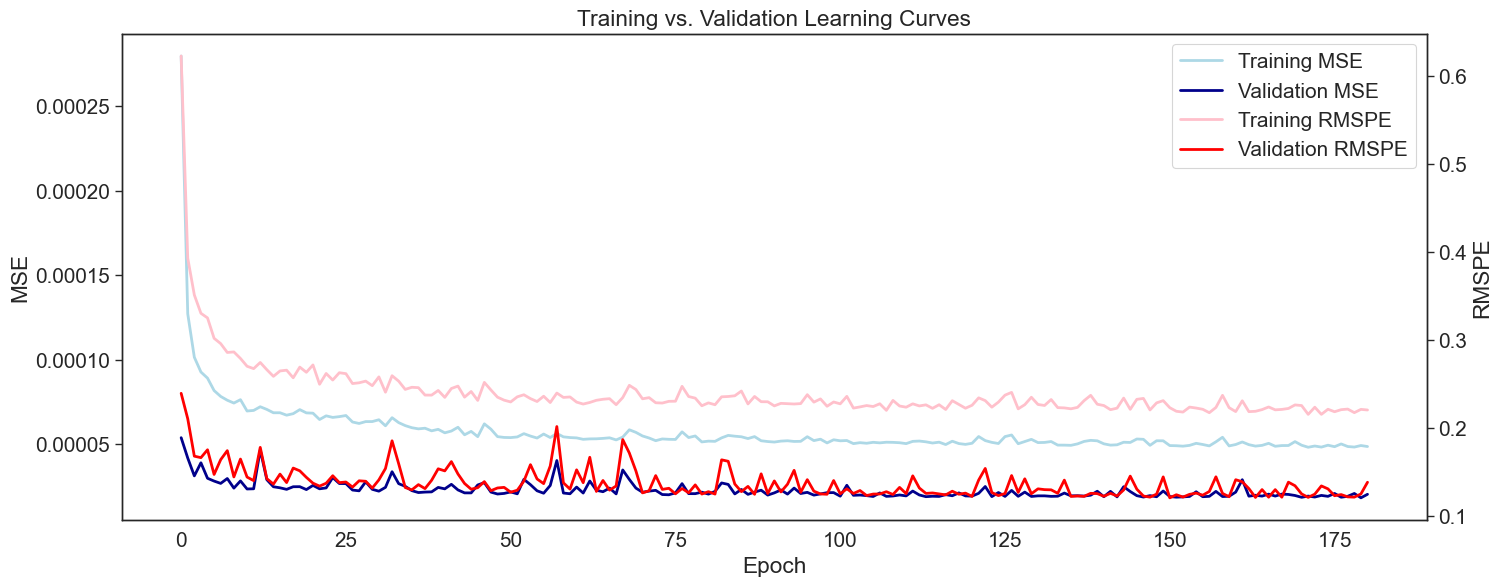

In [134]:
# VISUALIZING PERFORMANCE METRICS
viz_train_val_metrics(lstm_2_res)

In [135]:
# FORECASTING ON VALIDATION SET
lstm_2_preds = forecast(lstm_2, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_2_preds_scaled = scale(scaler_vol, lstm_2_preds)

12/12 [==============================] - 1s 2ms/step


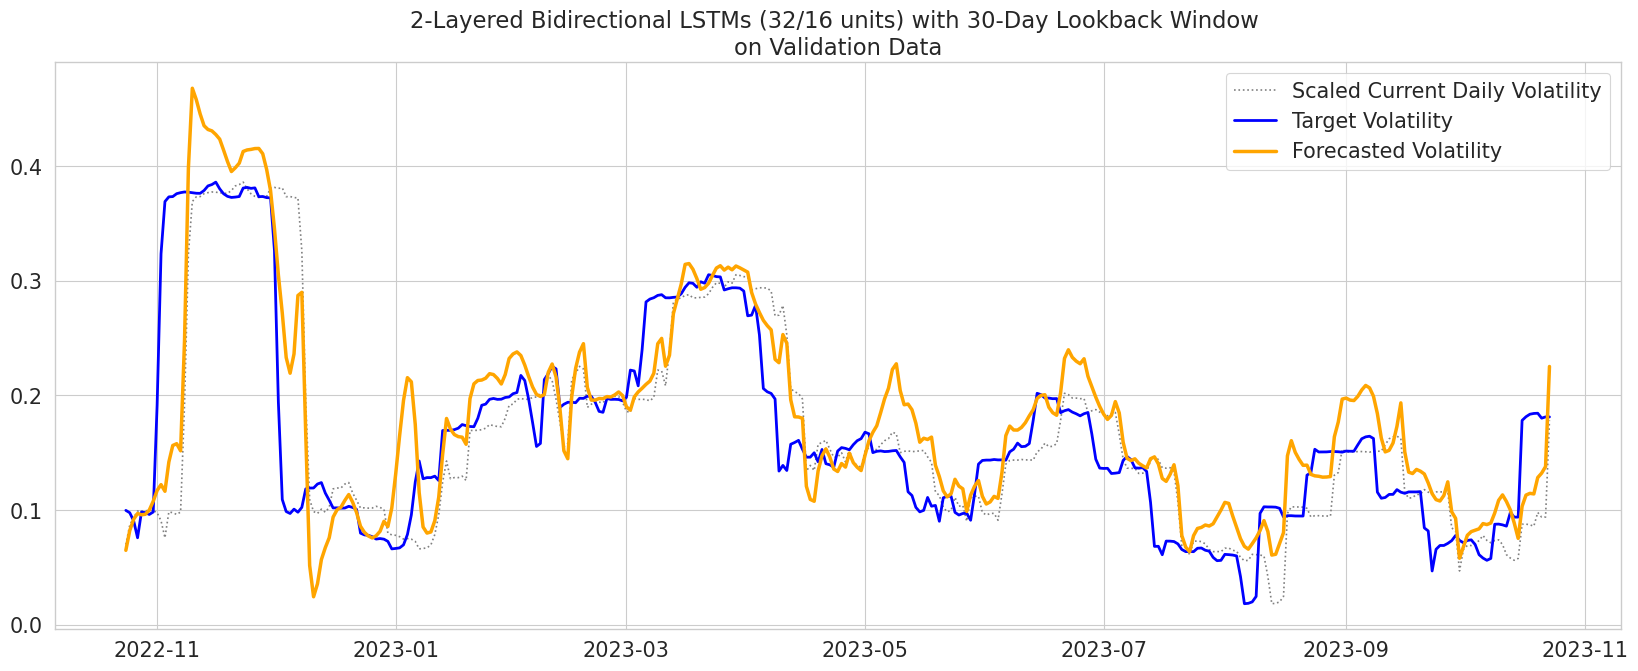

In [136]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTMs (32/16 units) with {n_past}-Day Lookback Window")
plt.savefig(os.path.join(directory_to_img, 'lstm_2.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [137]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units), n_past={n_past}")

Model  Validation RMSPE  \
0                                           Mean Baseline          2.254060   
1                           Random Walk Naive Forecasting          0.504028   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.506356   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.325928   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.438946   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.421078   
6     Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist          0.409257   
7                 Simple LR Fully Connected NN, n_past=14          0.679652   
8                        LSTM 1 layer 20 units, n_past=14          0.578908   
9         2 layers Bidirect LSTM (32/16 units), n_past=30          0.491862   

   Validation RMSE  
0         0.158991  
1         0.062188  
2         0.101584  
3         0.060217  
4         0.063662  
5         0.062941  
6         0.061094  
7         0.065121  
8         0.059545  
9         0.053075

### 4.4. Univariate Bidirectional LSTM + 1D Convolutional Layer(s)

In [138]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')
print(lstm_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160       
                                                                 
 bidirectional (Bidirection  (None, None, 64)          16640     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 27201 (106.25 KB)
Trainable params: 27201 

In [139]:
# FITTING MODEL TO TRAINING DATA
lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

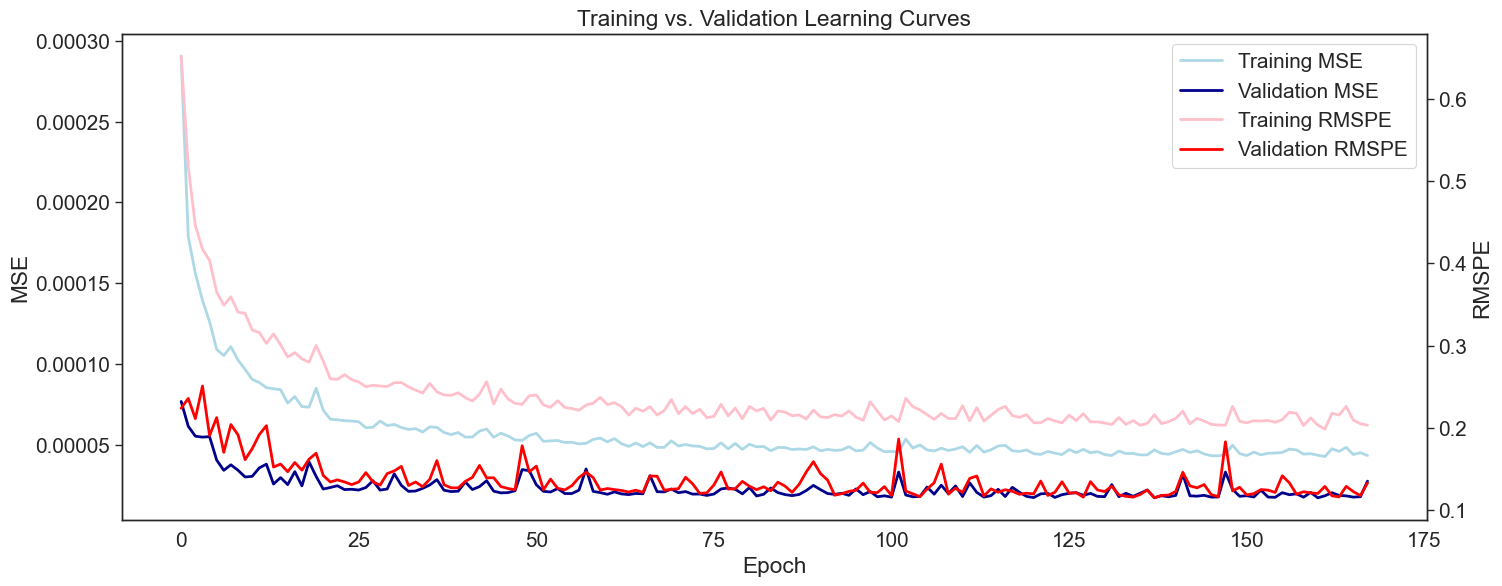

In [140]:
# VISUALIZING TRAINING/VALIDATION METRICS
viz_train_val_metrics(lstm_3_res)

In [141]:
# FORECASTING ON VALIDATION SET
lstm_3_preds = forecast(lstm_3, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_3_preds_scaled = scale(scaler_vol, lstm_3_preds)

12/12 [==============================] - 0s 2ms/step


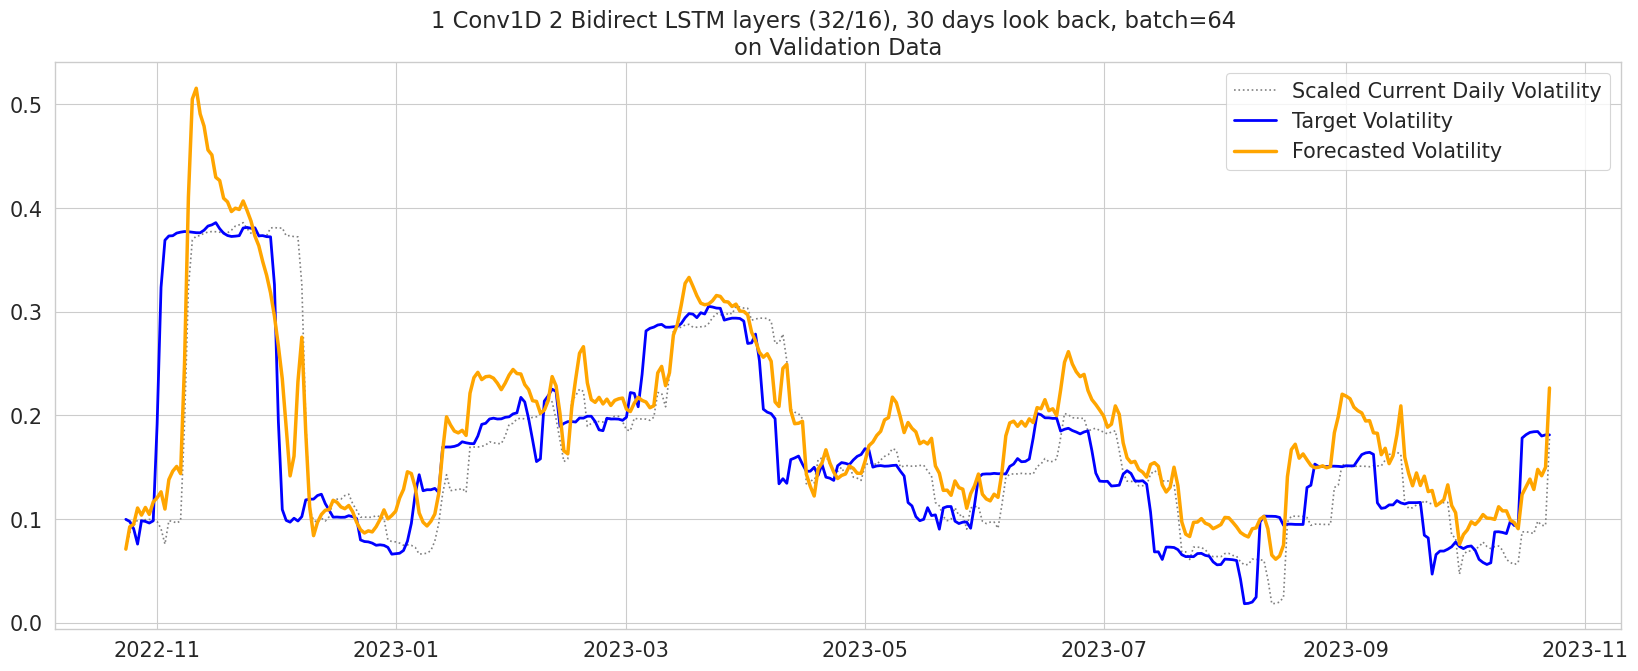

In [142]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, batch={batch_size}")
plt.savefig(os.path.join(directory_to_img, 'lstm_3.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [143]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past={n_past}, batch={batch_size}")

Model  \
0                                                  Mean Baseline   
1                                  Random Walk Naive Forecasting   
2                         GARCH(1,1), Constant Mean, Normal Dist   
3         Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5               Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6            Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
7                        Simple LR Fully Connected NN, n_past=14   
8                               LSTM 1 layer 20 units, n_past=14   
9                2 layers Bidirect LSTM (32/16 units), n_past=30   
10  1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   

    Validation RMSPE  Validation RMSE  
0           2.254060         0.158991  
1           0.504028         0.062188  
2           0.506356         0.101584  
3           0.325928         0.060217  
4           0.438946         0.063662  
5           0.421078         0.062941  
6           0.409257         0.061094  
7           0.679652         0.065121  
8           0.578908         0.059545  
9           0.491862         0.053075  
10          0.529098         0.053125

### 4.5. Learning Rate Tuning with SGD Optimizer

In [144]:
tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

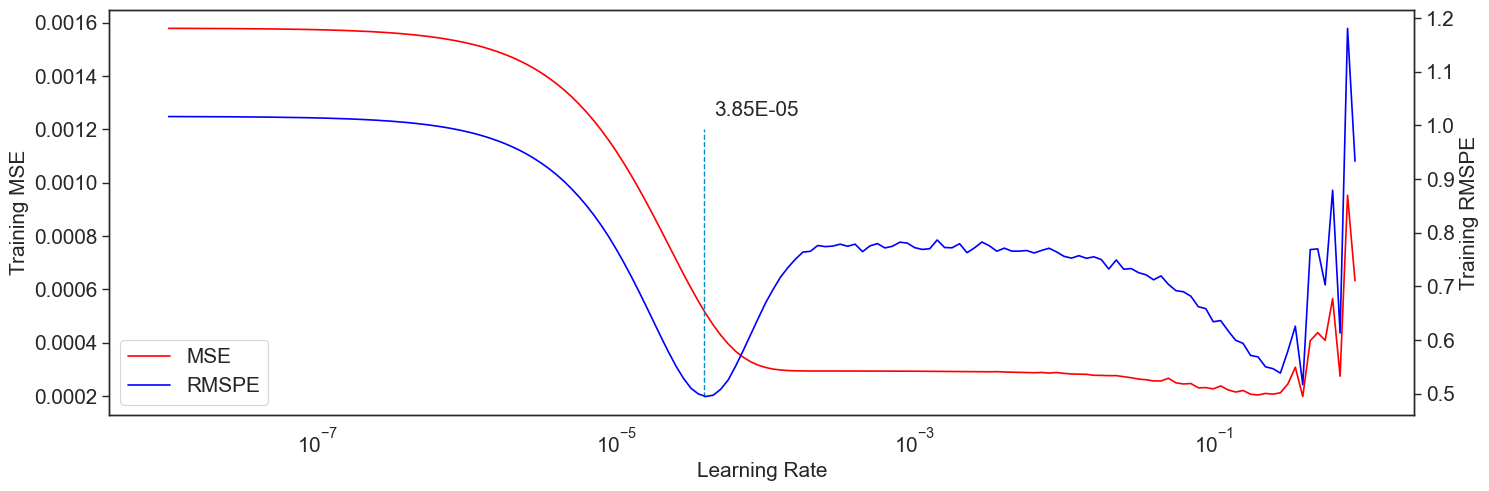

In [145]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(15,5))

    # PLOT MSE - LEFT Y-AXIS
    ln1 = ax.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['loss'], 
                color='red', label='MSE')
    ax.set_xlabel('Learning Rate', fontsize=15)
    ax.set_ylabel('Training MSE', fontsize=15)

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln2 = ax2.semilogx(lstm_4_res.history['lr'], lstm_4_res.history['rmspe'],
                color='blue', label='RMSPE')
    ax2.set_ylabel('Training RMSPE', fontsize=15)

    # COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='lower left')

    best_lr = 3.85e-5

    ax.vlines(x=best_lr, ls='--', lw=1,
            ymin=np.min(lstm_4_res.history["loss"]),
            ymax=0.0012)

    ax.text(4.5e-5, 0.00125, '%.2E' % Decimal(best_lr), fontsize=15)

    plt.show();

In [146]:
tf.keras.backend.clear_session()

np.random.seed(seed)

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd BIDIRECTIONAL LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_4.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

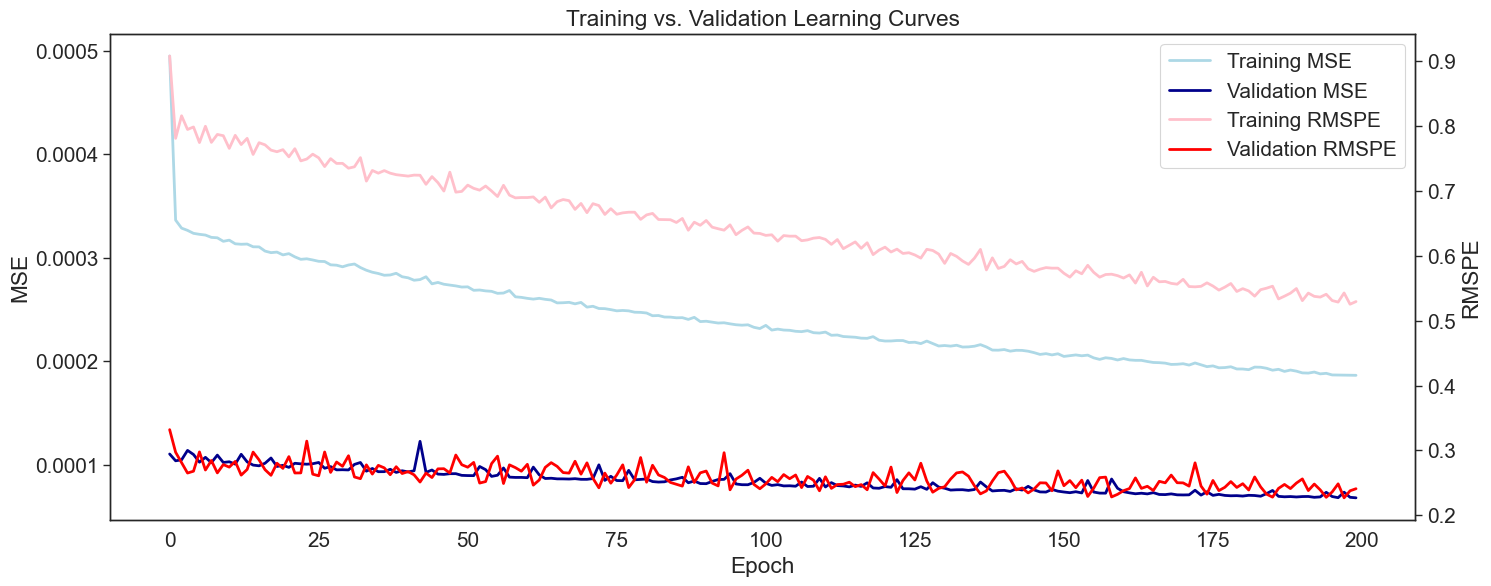

In [147]:
# VISUALIZING TRAINING/VALIDATION LEARNING CURVES
viz_train_val_metrics(lstm_4_res)

In [148]:
# FORECASTING ON VALIDATION SET
lstm_4_preds = forecast(lstm_4, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_4_preds_scaled = scale(scaler_vol, lstm_4_preds)

12/12 [==============================] - 0s 2ms/step


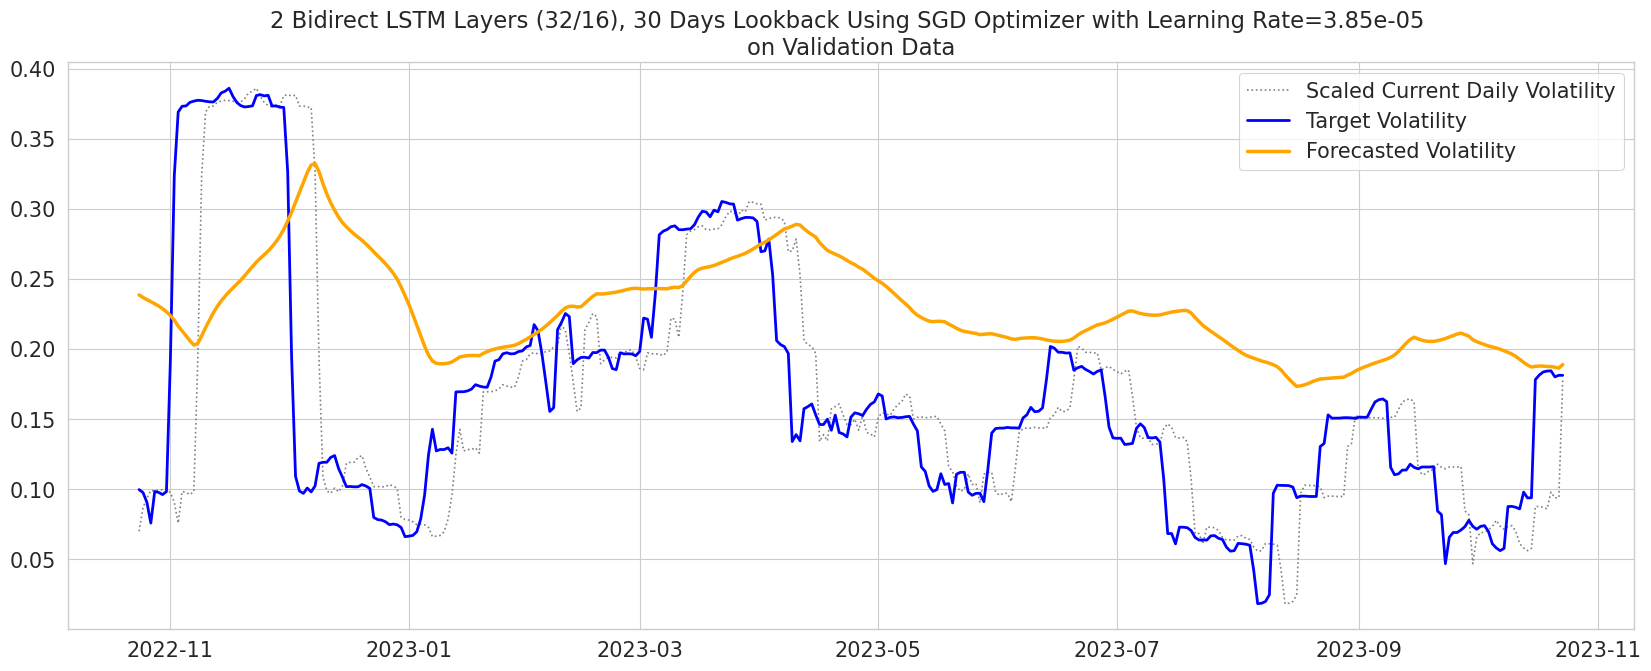

In [149]:
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"2 Bidirect LSTM Layers (32/16), {n_past} Days Lookback Using SGD Optimizer with Learning Rate={best_lr}")
plt.savefig(os.path.join(directory_to_img, 'lstm_4.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

In [150]:
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"2 Bidirect LSTMs (32/16), n_past={n_past}, batch={batch_size}, SGD lr={best_lr}")

Model  \
0                                                    Mean Baseline   
1                                    Random Walk Naive Forecasting   
2                           GARCH(1,1), Constant Mean, Normal Dist   
3           Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                  Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                 Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6              Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
7                          Simple LR Fully Connected NN, n_past=14   
8                                 LSTM 1 layer 20 units, n_past=14   
9                  2 layers Bidirect LSTM (32/16 units), n_past=30   
10    1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=3.85e-05   

    Validation RMSPE  Validation RMSE  
0           2.254060         0.158991  
1           0.504028         0.062188  
2           0.506356         0.101584  
3           0.325928         0.060217  
4           0.438946         0.063662  
5           0.421078         0.062941  
6           0.409257         0.061094  
7           0.679652         0.065121  
8           0.578908         0.059545  
9           0.491862         0.053075  
10          0.529098         0.053125  
11          1.429459         0.105426

### 4.6. Multivariate LSTM

In [151]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2015-01-31 00:00:00+00:00  226.440994  233.503998  216.309006  217.464005   
2015-02-01 00:00:00+00:00  216.867004  231.574005  212.014999  226.972000   
2015-02-02 00:00:00+00:00  226.490997  242.175003  222.658997  238.229004   
2015-02-03 00:00:00+00:00  237.453995  245.957001  224.483002  227.268005   
2015-02-04 00:00:00+00:00  227.511002  230.057999  221.113007  226.852997   

                             Volume   returns  log_returns  vol_current  \
Date                                                                      
2015-01-31 00:00:00+00:00  23348200 -3.957601    -0.040380     0.078597   
2015-02-01 00:00:00+00:00  29128500  4.372216     0.042793     0.078996   
2015-02-02 00:00:00+00:00  30612100  4.959644     0.048406     0.076635   
2015-02-03 00:00:00+00:00  40783700 -4.601034    -0.047102     0.076269   
2015-02-04 00:00:00+00:00  26594300 -0.182608    -0.001828     0.075940   

                           vol_future  
Date                                   
2015-01-31 00:00:00+00:00    0.075733  
2015-02-01 00:00:00+00:00    0.075679  
2015-02-02 00:00:00+00:00    0.075032  
2015-02-03 00:00:00+00:00    0.074769  
2015-02-04 00:00:00+00:00    0.074756

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3218 entries, 2015-01-31 00:00:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         3218 non-null   float64
 1   High         3218 non-null   float64
 2   Low          3218 non-null   float64
 3   Close        3218 non-null   float64
 4   Volume       3218 non-null   int64  
 5   returns      3218 non-null   float64
 6   log_returns  3218 non-null   float64
 7   vol_current  3218 non-null   float64
 8   vol_future   3218 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 380.4 KB


In [153]:
df.describe()

Open          High           Low         Close        Volume  \
count   3218.000000   3218.000000   3218.000000   3218.000000  3.218000e+03   
mean   14848.262943  15198.648907  14469.512375  14858.431514  1.718020e+10   
std    16088.085354  16480.233267  15645.397639  16087.835387  1.926483e+10   
min      210.067993    221.807007    199.567001    210.494995  1.060090e+07   
25%     1225.865051   1246.342529   1208.759979   1229.737457  4.135323e+08   
50%     8606.907227   8783.275879   8362.870117   8621.233398  1.274570e+10   
75%    23857.627441  24411.189453  23462.944336  23879.926270  2.772253e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3218.000000  3218.000000  3218.000000  3218.000000  
mean      0.226760     0.001587     0.034403     0.034285  
std       3.670996     0.036968     0.015985     0.015871  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.213176    -0.012206     0.023548     0.023464  
50%       0.142533     0.001424     0.032143     0.032097  
75%       1.697172     0.016829     0.043360     0.043311  
max      25.247169     0.225119     0.103878     0.103878

#### 4.6.1. Feature Engineering

In [154]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [155]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2015-01-31 00:00:00+00:00  226.440994  233.503998  216.309006  217.464005   
2015-02-01 00:00:00+00:00  216.867004  231.574005  212.014999  226.972000   
2015-02-02 00:00:00+00:00  226.490997  242.175003  222.658997  238.229004   
2015-02-03 00:00:00+00:00  237.453995  245.957001  224.483002  227.268005   
2015-02-04 00:00:00+00:00  227.511002  230.057999  221.113007  226.852997   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2015-01-31 00:00:00+00:00  16.966030 -3.957601    -0.040380     0.078597   
2015-02-01 00:00:00+00:00  17.187228  4.372216     0.042793     0.078996   
2015-02-02 00:00:00+00:00  17.236906  4.959644     0.048406     0.076635   
2015-02-03 00:00:00+00:00  17.523793 -4.601034    -0.047102     0.076269   
2015-02-04 00:00:00+00:00  17.096207 -0.182608    -0.001828     0.075940   

                           vol_future   HL_sprd   CO_sprd  
Date                                                       
2015-01-31 00:00:00+00:00    0.075733 -2.537415 -0.039644  
2015-02-01 00:00:00+00:00    0.075679 -2.451391  0.046595  
2015-02-02 00:00:00+00:00    0.075032 -2.501997  0.051825  
2015-02-03 00:00:00+00:00    0.074769 -2.359287 -0.042897  
2015-02-04 00:00:00+00:00    0.074756 -3.233208 -0.002892

In [156]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

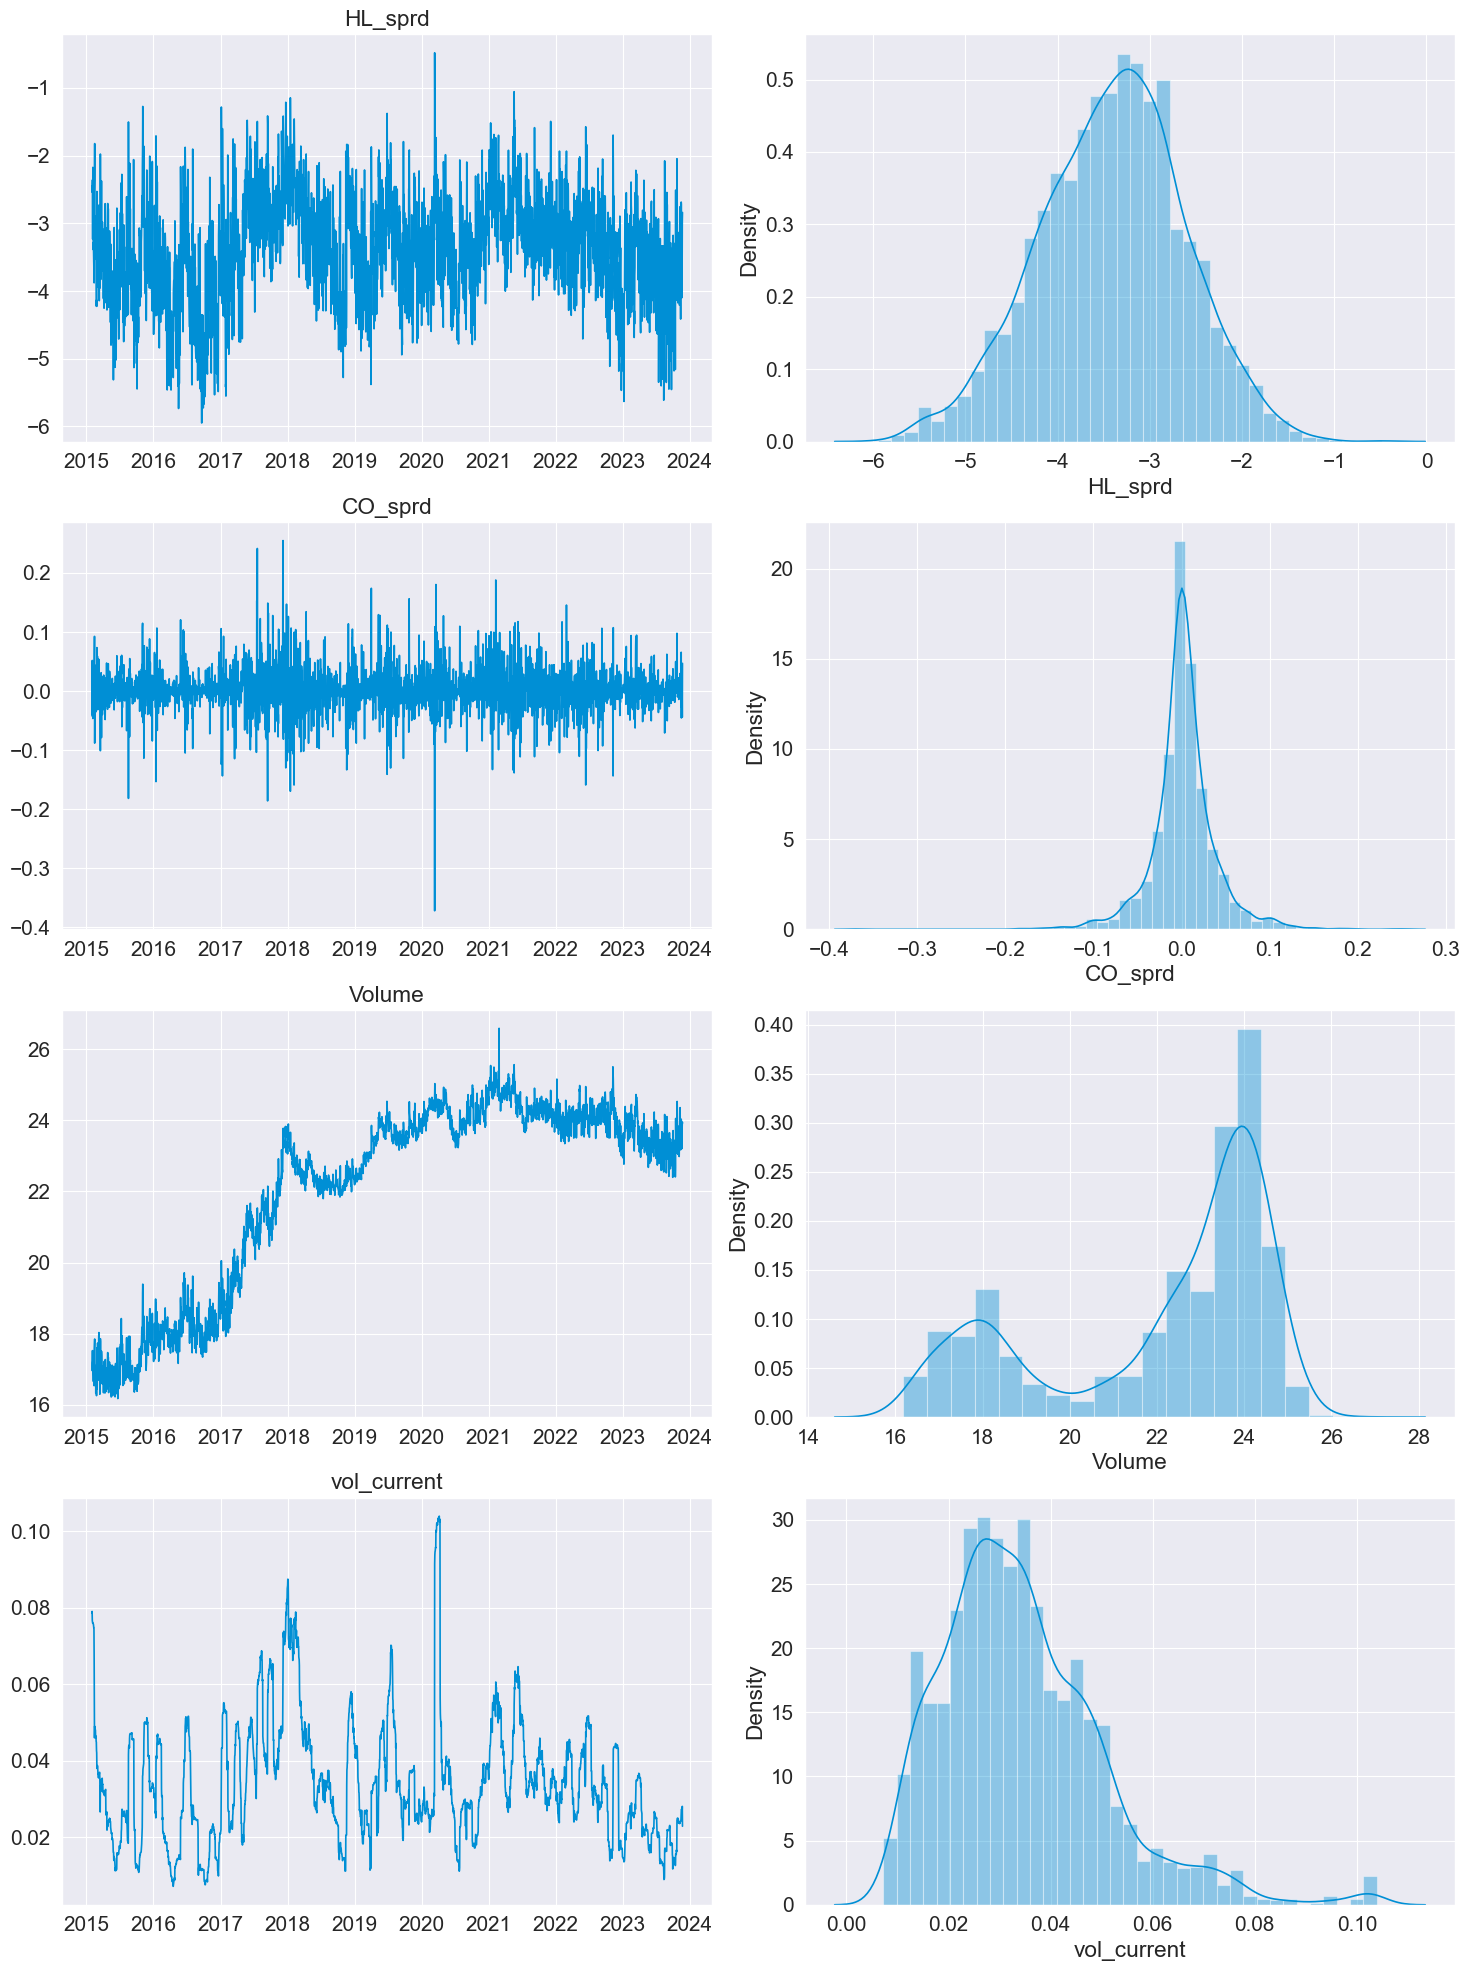

In [157]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'features.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

#### 4.6.2. Input Reshaping

In [158]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [159]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2015-01-31 00:00:00+00:00 -2.537415 -0.039644  16.966030     0.078597
2015-02-01 00:00:00+00:00 -2.451391  0.046595  17.187228     0.078996
2015-02-02 00:00:00+00:00 -2.501997  0.051825  17.236906     0.076635
2015-02-03 00:00:00+00:00 -2.359287 -0.042897  17.523793     0.076269
2015-02-04 00:00:00+00:00 -3.233208 -0.002892  17.096207     0.075940

In [160]:
input_df.head()

HL_sprd   CO_sprd     Volume  vol_current
Date                                                                 
2015-01-31 00:00:00+00:00 -2.537415 -0.039644  16.966030     0.078597
2015-02-01 00:00:00+00:00 -2.451391  0.046595  17.187228     0.078996
2015-02-02 00:00:00+00:00 -2.501997  0.051825  17.236906     0.076635
2015-02-03 00:00:00+00:00 -2.359287 -0.042897  17.523793     0.076269
2015-02-04 00:00:00+00:00 -3.233208 -0.002892  17.096207     0.075940

In [161]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2823 entries, 2015-01-31 00:00:00+00:00 to 2022-10-23 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2823 non-null   float64
 1   CO_sprd      2823 non-null   float64
 2   Volume       2823 non-null   float64
 3   vol_current  2823 non-null   float64
dtypes: float64(4)
memory usage: 110.3 KB


In [162]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3218 entries, 2015-01-31 00:00:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      3218 non-null   float64
 1   CO_sprd      3218 non-null   float64
 2   Volume       3218 non-null   float64
 3   vol_current  3218 non-null   float64
dtypes: float64(4)
memory usage: 254.7 KB


In [163]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

In [164]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [165]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

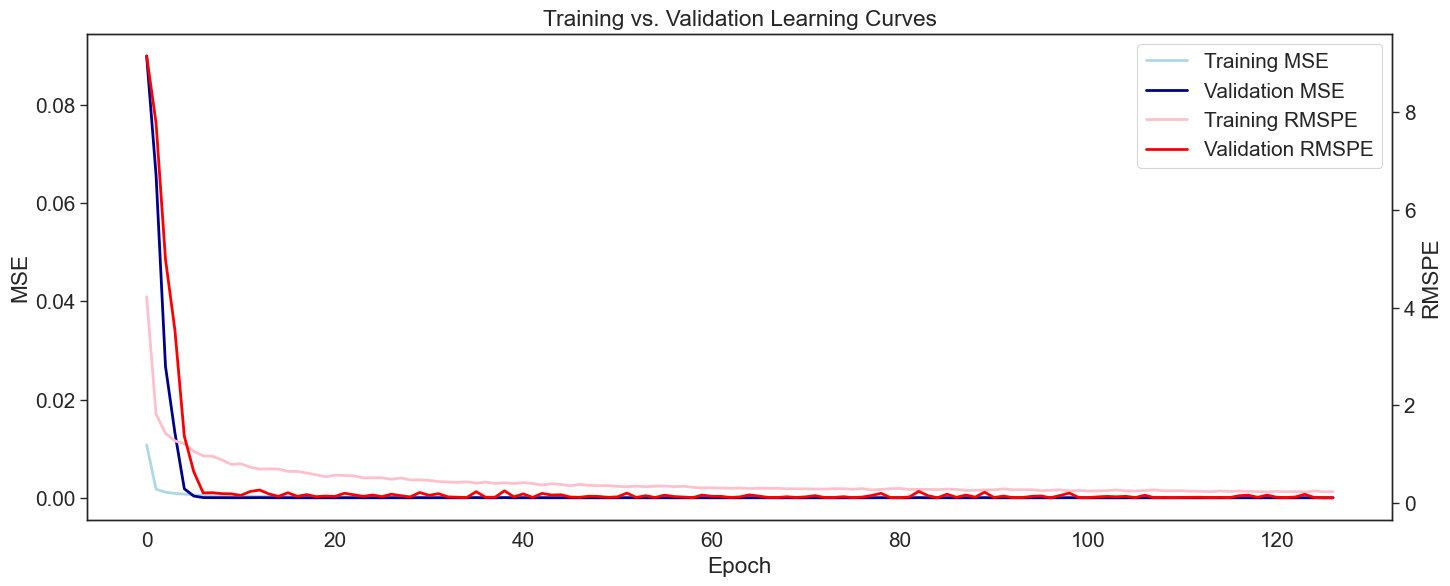

In [166]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [167]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 1s 2ms/step


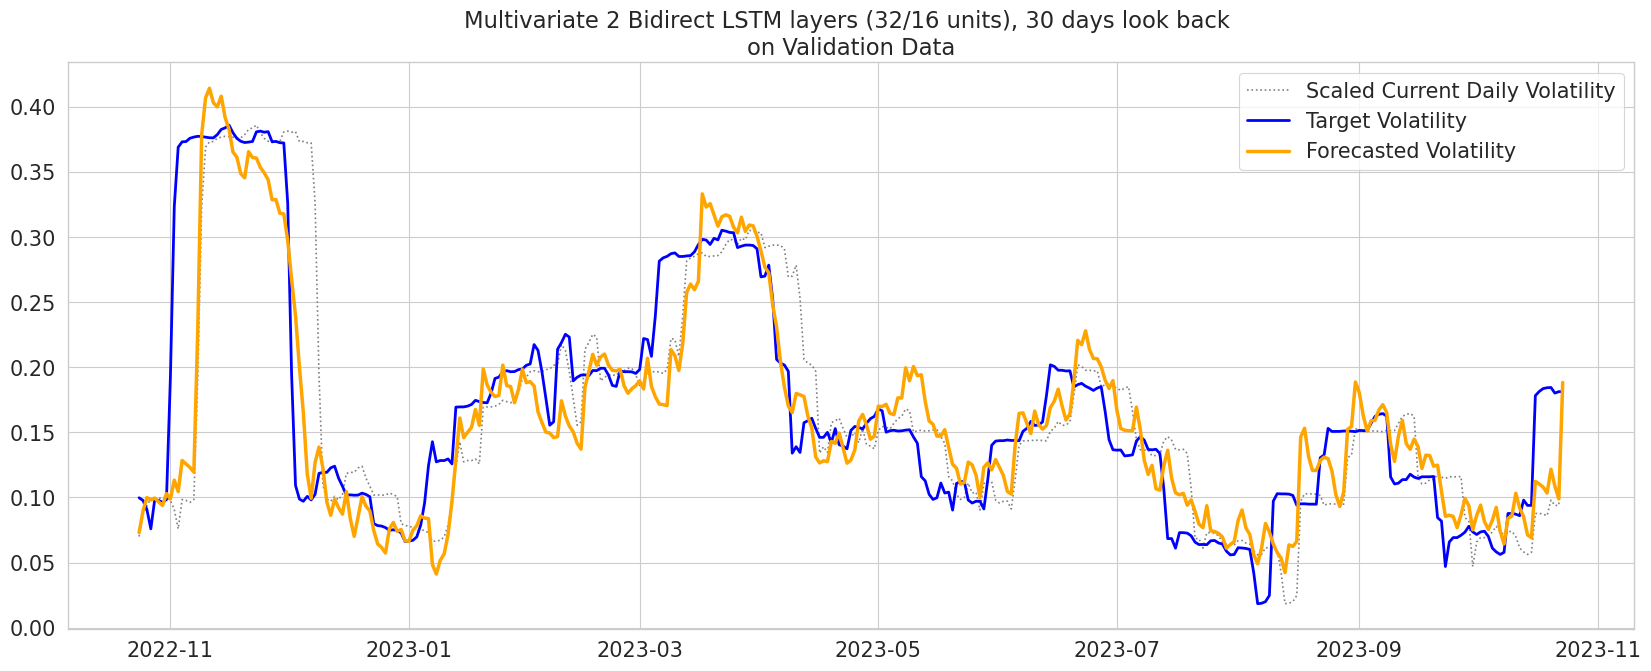

In [169]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_5.png'), 
            dpi=300) # bbox_inch='tight'
plt.show()

In [170]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

Model  \
0                                                    Mean Baseline   
1                                    Random Walk Naive Forecasting   
2                           GARCH(1,1), Constant Mean, Normal Dist   
3           Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                  Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                 Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6              Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
7                          Simple LR Fully Connected NN, n_past=14   
8                                 LSTM 1 layer 20 units, n_past=14   
9                  2 layers Bidirect LSTM (32/16 units), n_past=30   
10    1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11  2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=3.85e-05   
12    Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   

    Validation RMSPE  Validation RMSE  
0           2.254060         0.158991  
1           0.504028         0.062188  
2           0.506356         0.101584  
3           0.325928         0.060217  
4           0.438946         0.063662  
5           0.421078         0.062941  
6           0.409257         0.061094  
7           0.679652         0.065121  
8           0.578908         0.059545  
9           0.491862         0.053075  
10          0.529098         0.053125  
11          1.429459         0.105426  
12          0.358837         0.046810

### 4.8. Multivariate 3-Layered Bidirectional LSTM

In [171]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 
    
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           35328     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [172]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

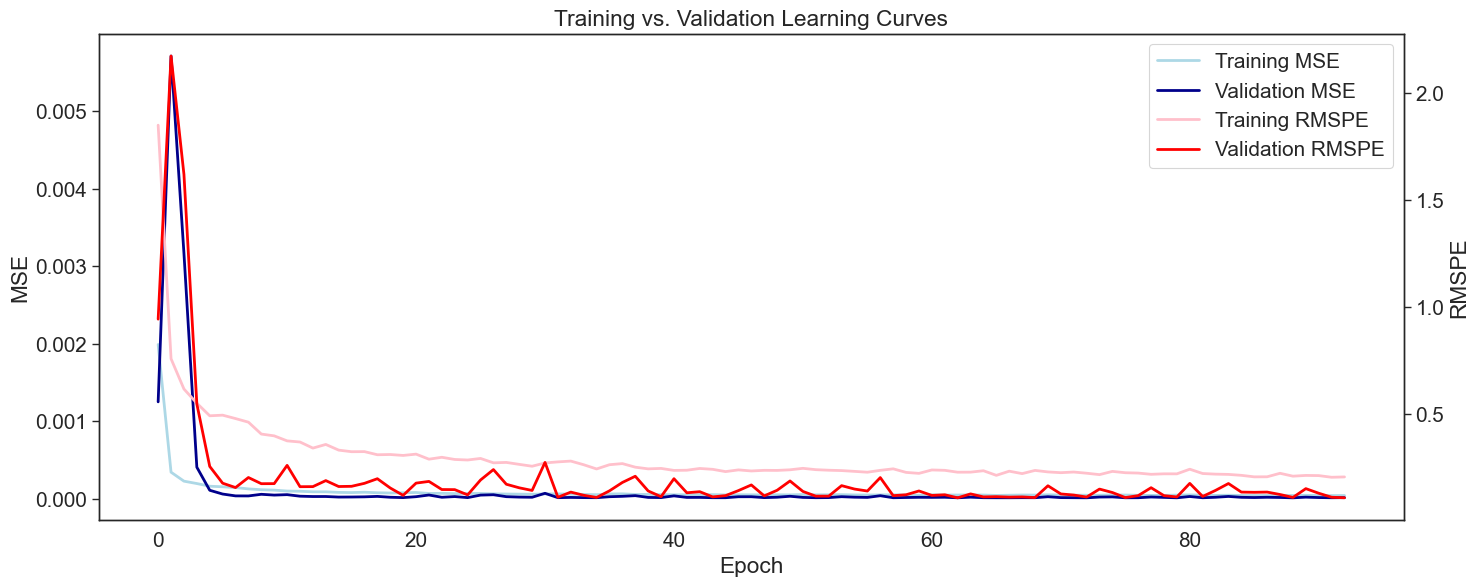

In [173]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [174]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 1s 4ms/step


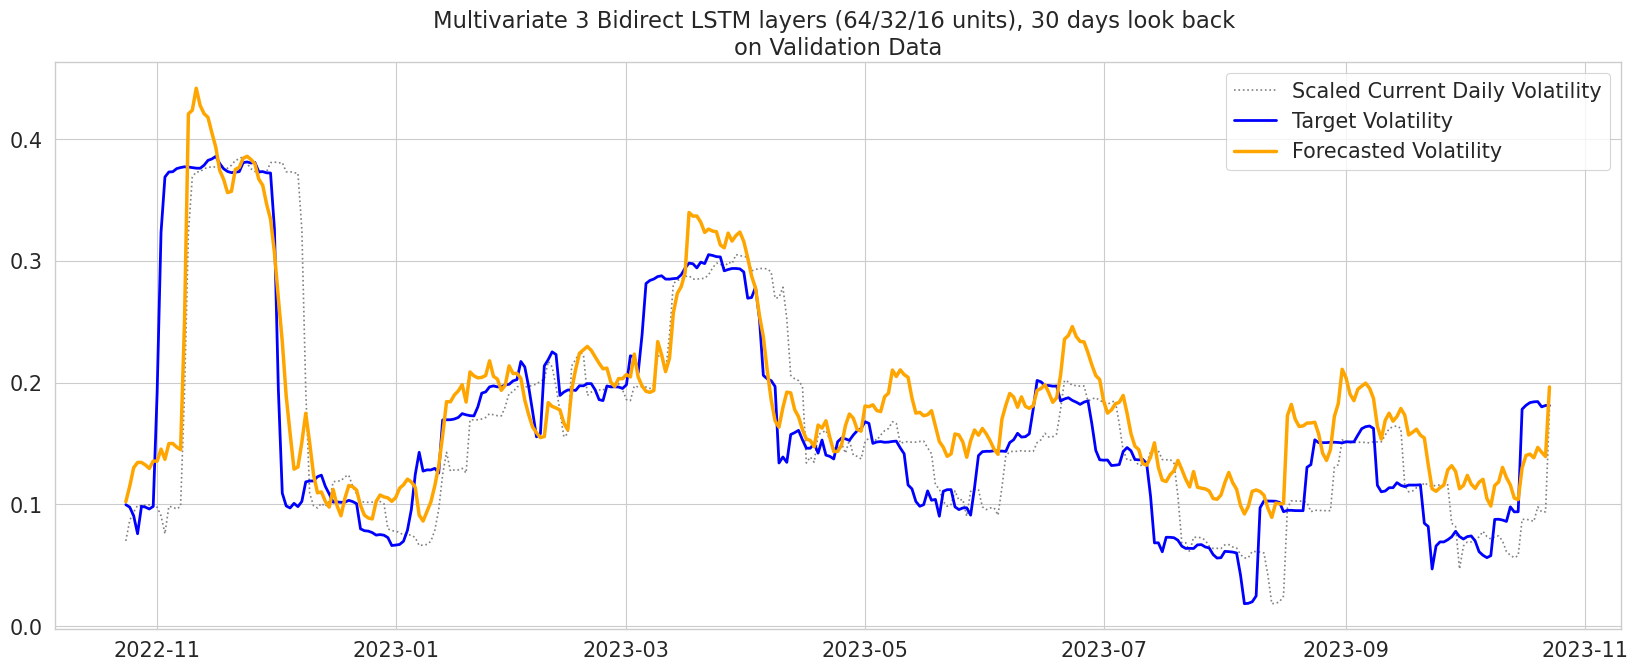

In [175]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (64/32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_6.png'), 
            dpi=300) # bbox_inch='tight'
plt.show()

In [176]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

Model  \
0                                                     Mean Baseline   
1                                     Random Walk Naive Forecasting   
2                            GARCH(1,1), Constant Mean, Normal Dist   
3            Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                   Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                  Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6               Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
7                           Simple LR Fully Connected NN, n_past=14   
8                                  LSTM 1 layer 20 units, n_past=14   
9                   2 layers Bidirect LSTM (32/16 units), n_past=30   
10     1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11   2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=3.85e-05   
12     Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
13  Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   

    Validation RMSPE  Validation RMSE  
0           2.254060         0.158991  
1           0.504028         0.062188  
2           0.506356         0.101584  
3           0.325928         0.060217  
4           0.438946         0.063662  
5           0.421078         0.062941  
6           0.409257         0.061094  
7           0.679652         0.065121  
8           0.578908         0.059545  
9           0.491862         0.053075  
10          0.529098         0.053125  
11          1.429459         0.105426  
12          0.358837         0.046810  
13          0.589142         0.049280

### 4.8. Multivariate 4-Layered Bidirectional LSTM

In [177]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 256)           136192    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [178]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

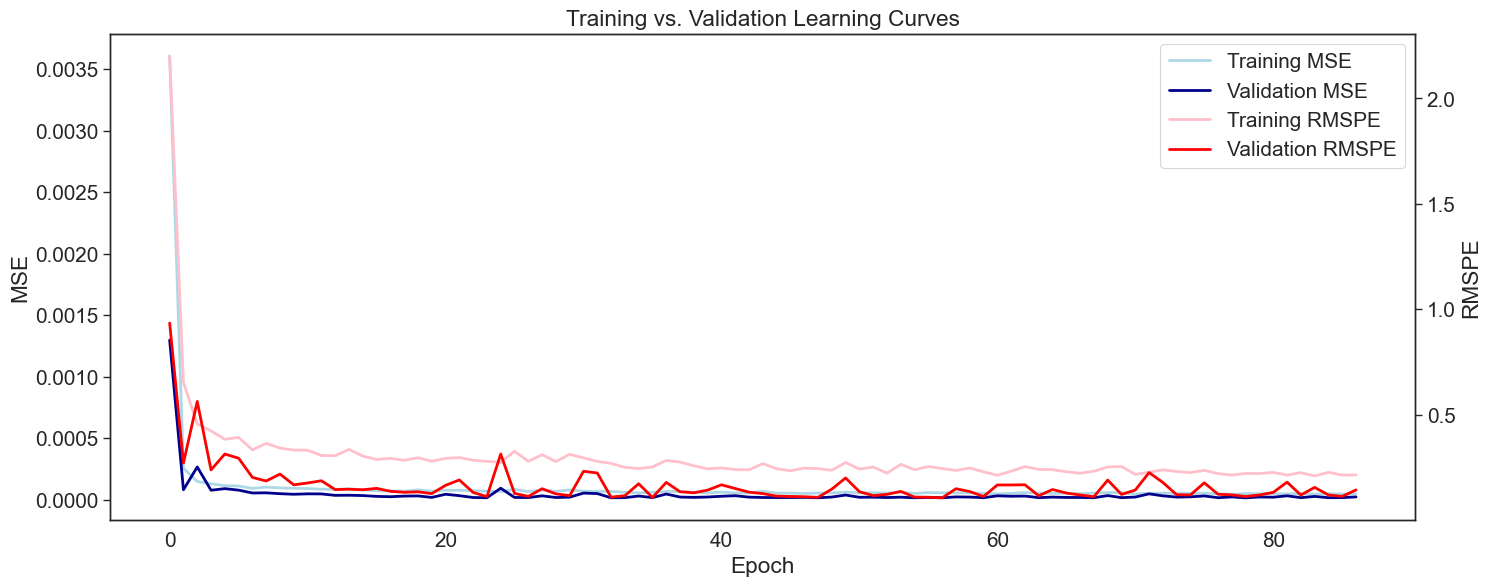

In [179]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)

In [180]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 1s 13ms/step


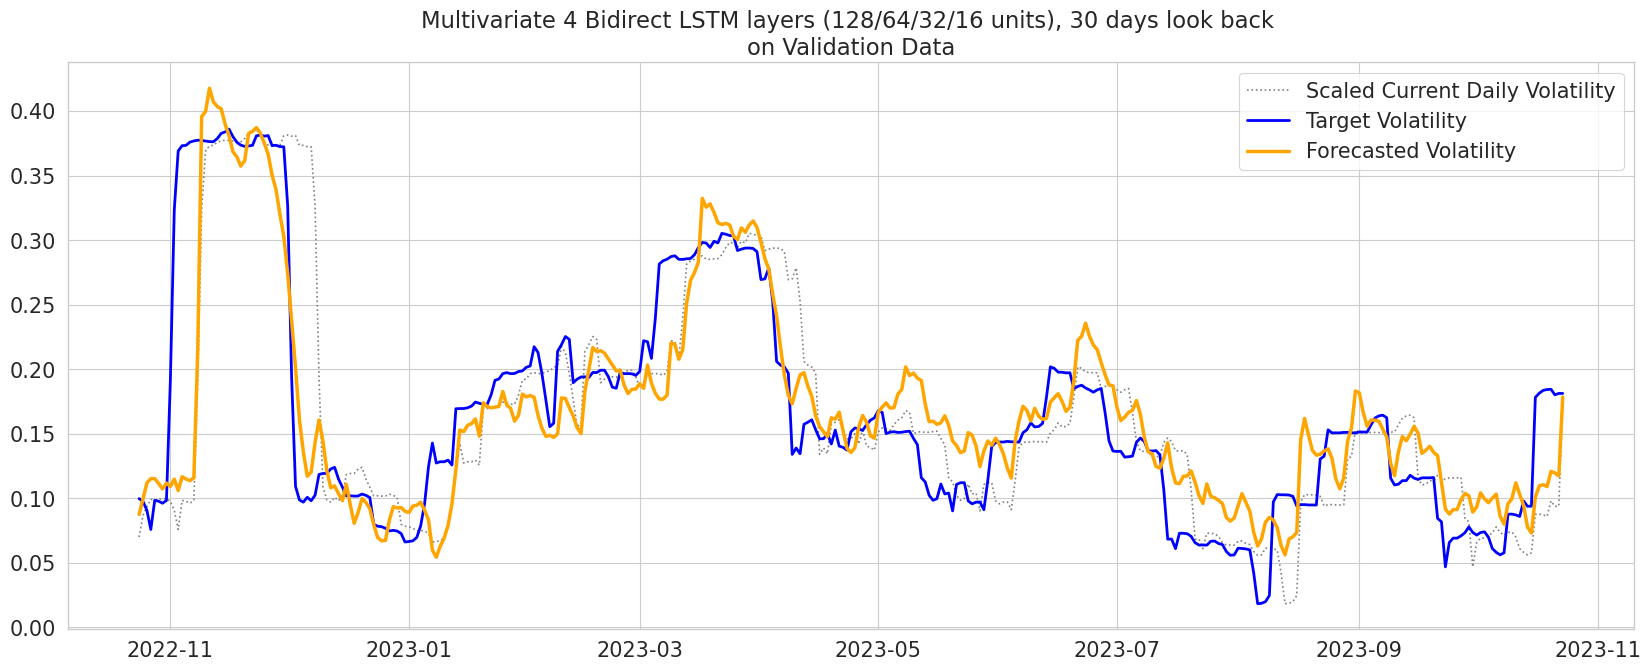

In [181]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), {n_past} days look back")
plt.savefig(os.path.join(directory_to_img, 'lstm_7_preds.png'), 
            dpi=300) # bbox_inches='tight'
plt.show();

In [182]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                                                   Mean Baseline   
1                                                   Random Walk Naive Forecasting   
2                                          GARCH(1,1), Constant Mean, Normal Dist   
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
5                                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
6                             Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
7                                         Simple LR Fully Connected NN, n_past=14   
8                                                LSTM 1 layer 20 units, n_past=14   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
11                 2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=3.85e-05   
12                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
13                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
14  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   

    Validation RMSPE  Validation RMSE  
0           2.254060         0.158991  
1           0.504028         0.062188  
2           0.506356         0.101584  
3           0.325928         0.060217  
4           0.438946         0.063662  
5           0.421078         0.062941  
6           0.409257         0.061094  
7           0.679652         0.065121  
8           0.578908         0.059545  
9           0.491862         0.053075  
10          0.529098         0.053125  
11          1.429459         0.105426  
12          0.358837         0.046810  
13          0.589142         0.049280  
14          0.414962         0.047694

## **Final Model**

In [187]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

Model  \
3                          Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist   
12                   Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30   
6                             Bootstrap TARCH(1, 2, 2), Constant Mean, Skewt Dist   
14  Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past=30, batch=64   
5                                Simulation TARCH(1,1), Constant Mean, Skewt Dist   
4                                 Bootstrap TARCH(1,1), Constant Mean, Skewt Dist   
9                                 2 layers Bidirect LSTM (32/16 units), n_past=30   
1                                                   Random Walk Naive Forecasting   
2                                          GARCH(1,1), Constant Mean, Normal Dist   
10                   1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64   
8                                                LSTM 1 layer 20 units, n_past=14   
13                Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past=30   
7                                         Simple LR Fully Connected NN, n_past=14   
11                 2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=3.85e-05   
0                                                                   Mean Baseline   

    Validation RMSPE  Validation RMSE  
3           0.325928         0.060217  
12          0.358837         0.046810  
6           0.409257         0.061094  
14          0.414962         0.047694  
5           0.421078         0.062941  
4           0.438946         0.063662  
9           0.491862         0.053075  
1           0.504028         0.062188  
2           0.506356         0.101584  
10          0.529098         0.053125  
8           0.578908         0.059545  
13          0.589142         0.049280  
7           0.679652         0.065121  
11          1.429459         0.105426  
0           2.254060         0.158991

In [188]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [189]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 4)             16        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            9472      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [190]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

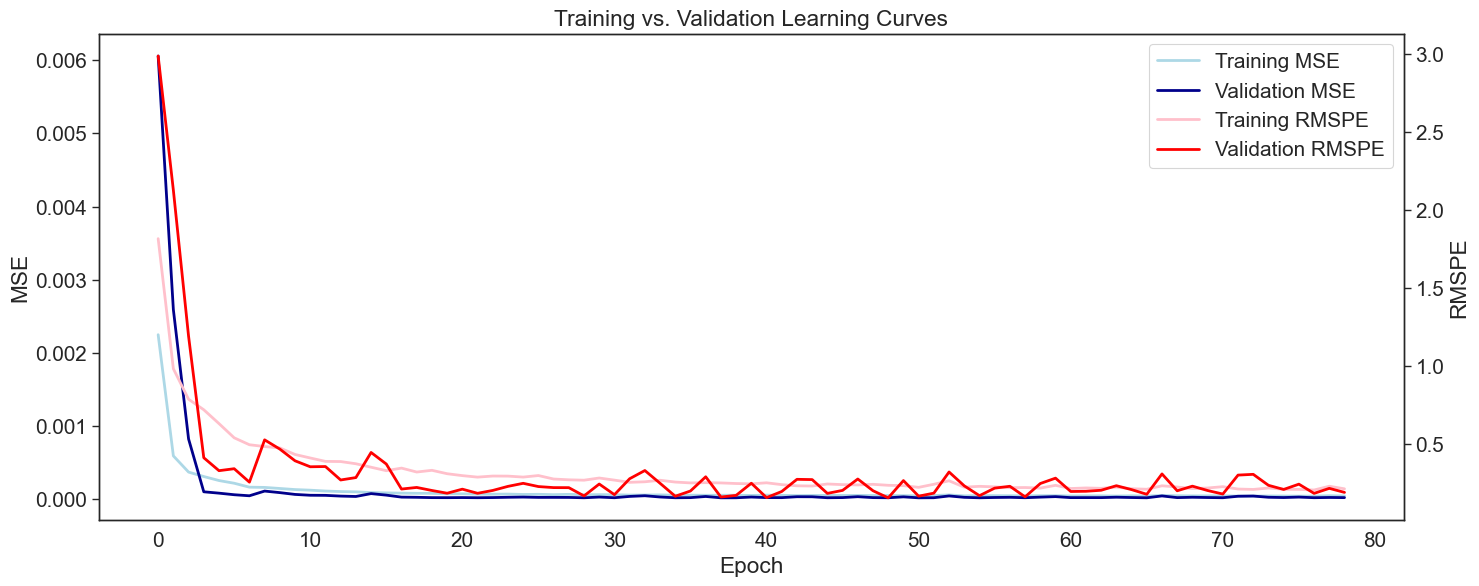

In [191]:
viz_train_val_metrics(lstm_final_res)

### Final Model's Predictions on Test Set

In [192]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

1/1 [==============================] - 1s 512ms/step


In [193]:
y_test_preds.describe()

count    30.000000
mean      0.024742
std       0.001915
min       0.021219
25%       0.023459
50%       0.024695
75%       0.025634
max       0.028456
dtype: float64

In [194]:
y_test.describe()

count    30.000000
mean      0.024294
std       0.001745
min       0.022265
25%       0.023098
50%       0.023961
75%       0.024618
max       0.028103
Name: vol_future, dtype: float64

In [195]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [196]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

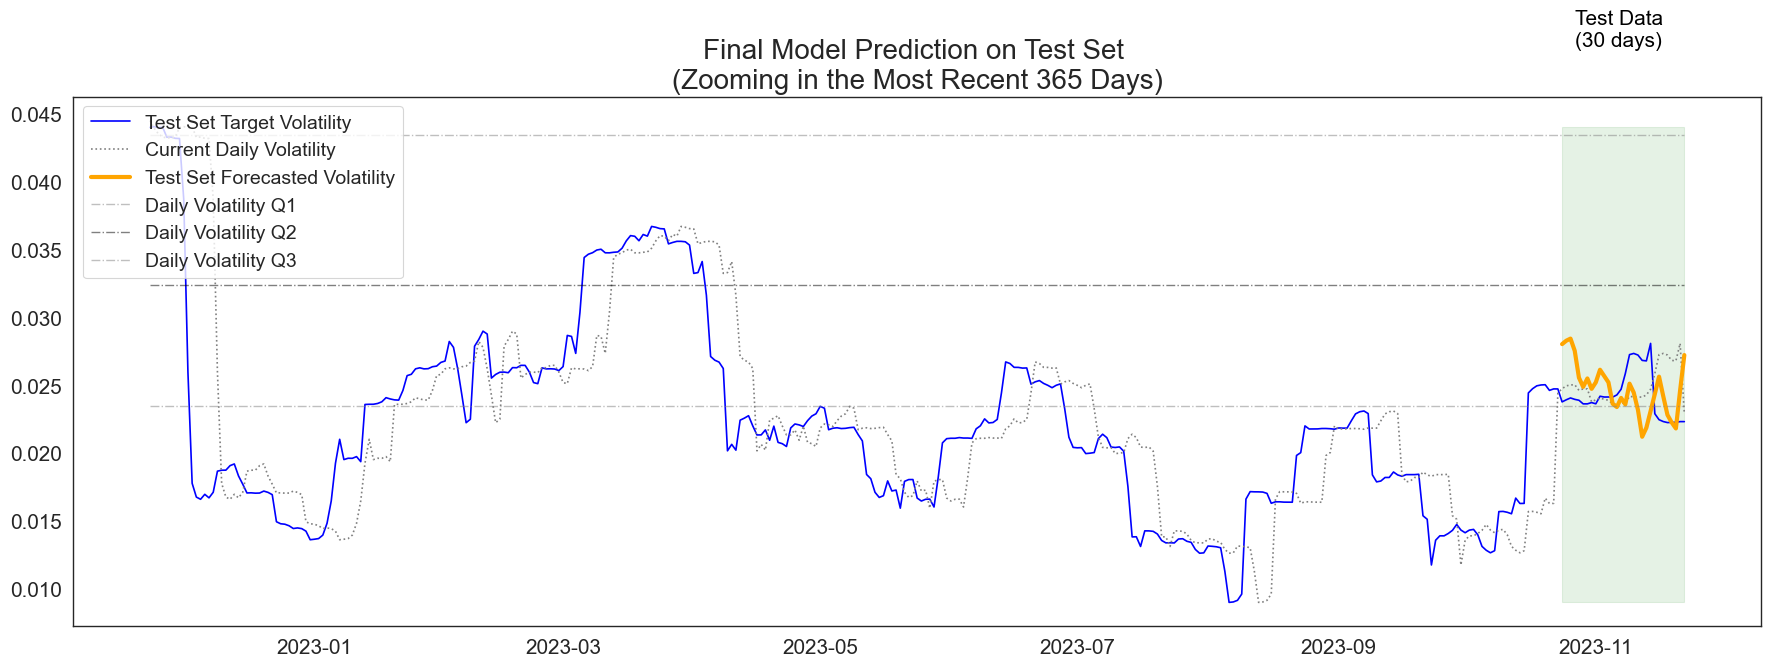

In [197]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [198]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

100/100 [==============================] - 0s 4ms/step


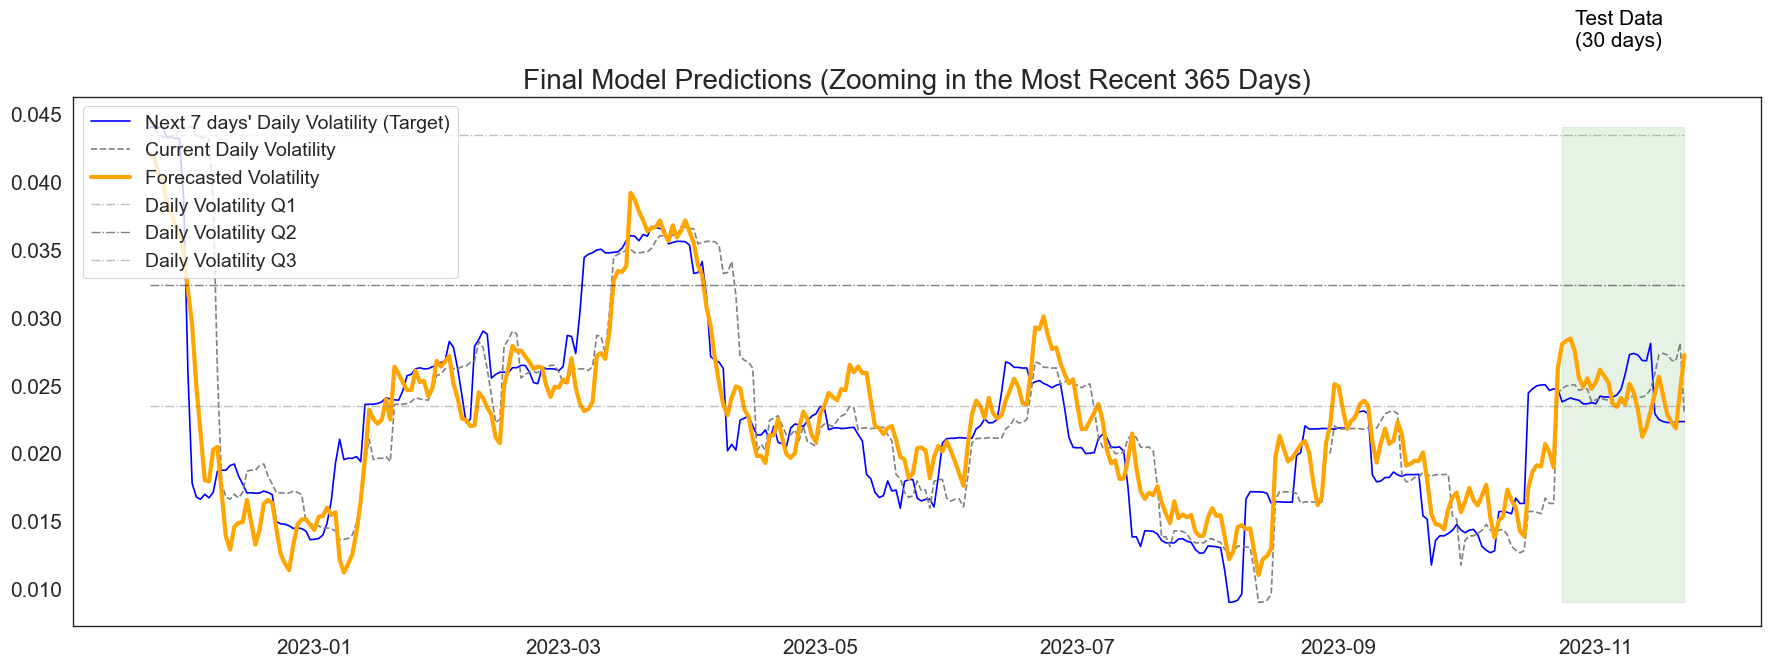

In [199]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [200]:
perf_df.to_pickle("performance_df.pkl")

In [201]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

RMSPE on Test Set: 0.11589946073115125


In [202]:
1-RMSPE(y_test, y_test_preds)

0.8841005392688488